<font color='#9999ff' face='Tahoma' size=6>Exploratory Data Analysis  |  Base 7 días</font>

<font face='Arial' size=3>Exploratory Data Analysis: se analiza y explora un conjunto de datos para comprender sus características, descubrir patrones, detectar anomalías, etc.</font>

<font face='Arial' size=3>Se analiza libremente basandose en principios de estadística, según los requerimientos de cada variable.</font>

***

In [1]:
import sys
sys.path.append('/workspaces/atrato-data-ds-collection-score')

In [2]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import bisect
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, confusion_matrix, classification_report, roc_auc_score, accuracy_score, precision_score, f1_score, roc_curve, precision_recall_curve, auc
from sklearn.linear_model import Lasso
from xgboost import XGBClassifier
from collections import Counter
from tabulate import tabulate
import time
from joblib import Parallel, delayed

In [3]:
from tools.features import *
from tools.utils import *

In [4]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)

In [5]:
df = pd.read_csv('../../../data_no_dvc/BASE_COLLECTION_SCORE_7_DAYS_202412021730.csv')
len(df)

128888

In [6]:
del df['payment_promise_amount']
del df['payment_promise']
del df['sub7_days_delays_count']
del df['epdscore'] #Se elimina ya que se acaba de recalibrar y los clientes recurrentes ya no pasan por el flujo de donde se obtiene esta métrica

# target 60 días descartado para modelo primario
#del df['target_52_days']
#Dejo por ahora el target de 60 días para construir el target de bucket y comparar al mismo tiempo en la matriz de correlación

In [7]:
df

,idobservation,id_solicitud,id_userv3,payment_history,max_overdue,ratio_overdue_payments,max_overdue_amount,granted_credit_amount,pct_credit_maturity,risk_profile_v1,risk_profile_v2,num_atrato_credits,early_settled_atrato_credits,pending_late_commission_amount,paid_late_commission_amount,montlhy_payment,has_mortgage_overdue,monthly_payment_terms,age,gender,payments_before_first_overdue,payments_before_worst_overdue,days_of_worst_overdue,has_mortgage_or_large_loans,current_debt,historical_overdue_atrato_credits,dashboard_inquiries,most_used_paymentmethod,owed_amount_cc,num_expected_payments_monthly,target_7_days,target_52_days,credito_created_at_utc
0,3187-15,3187,6117,"-26,-33,-29,-32,-30,0",NaN,NaN,NaN,15000.00,0.305,NaN,NaN,1.0,NaN,NaN,NaN,1344.717480,NaN,18,41,Hombre,NaN,NaN,NaN,NaN,0.695,1.0,NaN,NaN,0.0,15,1,1,2020-08-28 18:38:56.000
1,4557-11,4557,6146,"3,3,0,1,0,2,0",3.0,0.222,3428.98000,40000.00,0.374,NaN,NaN,1.0,NaN,NaN,NaN,3428.981610,0.0,18,46,Hombre,6.0,26.0,3.0,1.0,0.626,1.0,NaN,NaN,0.0,11,1,0,2020-08-28 18:51:18.000
2,4557-10,4557,6146,"3,3,0,1,0,2,0",3.0,0.222,3428.98000,40000.00,0.374,NaN,NaN,1.0,NaN,NaN,NaN,3428.981610,0.0,18,46,Hombre,7.0,32.0,3.0,1.0,0.626,1.0,NaN,NaN,0.0,10,1,0,2020-08-28 18:51:18.000
3,4557-12,4557,6146,"35,44,3,3,0,1,0,2,0",14.0,0.333,3577.99839,40000.00,0.493,NaN,NaN,1.0,NaN,150.0,150.0,3428.981610,0.0,18,46,Hombre,8.0,41.0,14.0,1.0,0.507,1.0,NaN,NaN,0.0,12,1,0,2020-08-28 18:51:18.000
4,6617-8,6617,6167,"0,-2,0,0,0",NaN,NaN,NaN,7000.00,0.535,C1,NaN,1.0,NaN,NaN,NaN,927.488565,NaN,9,24,Hombre,NaN,NaN,NaN,NaN,0.465,1.0,NaN,BBVA Practicaja,0.0,8,1,1,2020-08-28 18:59:15.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128883,1839553-1,1839553,677677,NaN,NaN,NaN,NaN,9965.51,NaN,B1,B1,1.0,NaN,300.0,NaN,1707.550000,0.0,9,43,Hombre,NaN,NaN,NaN,1.0,NaN,NaN,4.0,NaN,31283.0,1,0,0,2024-09-20 00:10:45.000
128884,1848484-2,1848484,681316,0,NaN,NaN,NaN,3899.00,0.057,C3,C2,1.0,NaN,NaN,NaN,479.780000,NaN,12,38,Hombre,NaN,NaN,NaN,NaN,0.943,1.0,8.0,PayAnywhere,1397.0,2,0,0,2024-09-22 22:49:39.000
128885,1863038-1,1863038,686747,NaN,NaN,NaN,NaN,8000.00,0.051,A3,B2,1.0,NaN,NaN,NaN,1100.370000,NaN,12,41,Hombre,NaN,NaN,NaN,NaN,0.950,NaN,18.0,OxxoPay,0.0,1,1,0,2024-10-06 01:01:48.000
128886,1881777-1,1881777,105450,NaN,NaN,NaN,NaN,11200.00,0.000,C2,A1,3.0,2.0,300.0,NaN,1197.420000,NaN,24,42,Hombre,NaN,NaN,NaN,NaN,1.000,2.0,121.0,OxxoPay,189.0,1,0,0,2024-10-11 14:16:47.000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128888 entries, 0 to 128887
Data columns (total 33 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   idobservation                      128888 non-null  object 
 1   id_solicitud                       128888 non-null  int64  
 2   id_userv3                          128888 non-null  int64  
 3   payment_history                    114954 non-null  object 
 4   max_overdue                        92054 non-null   float64
 5   ratio_overdue_payments             92054 non-null   float64
 6   max_overdue_amount                 92088 non-null   float64
 7   granted_credit_amount              128888 non-null  float64
 8   pct_credit_maturity                119554 non-null  float64
 9   risk_profile_v1                    128485 non-null  object 
 10  risk_profile_v2                    123641 non-null  object 
 11  num_atrato_credits                 1288

## Calculo de las variables del payment history

In [9]:
df_con_payment_history = df[~df['payment_history'].isna()]

In [10]:
resultados = df_con_payment_history.groupby('id_userv3').apply(aplicar_funciones_por_solicitud).reset_index(drop=True)

/tmp/ipykernel_1343/2826079949.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  resultados = df_con_payment_history.groupby('id_userv3').apply(aplicar_funciones_por_solicitud).reset_index(drop=True)


In [11]:
resultados

,id_solicitud,idobservation,current_credit_delay_trend,average_current_credit_delay,sum_credits_was_late,avg_period_between_overdue,num_roll_up,num_roll_down,num_bucket_1,num_bucket_2,num_bucket_3
0,443088,443088-4,0.00,0.000000,1,0.500000,0,1,2,0,0
1,443088,443088-5,-5.50,7.250000,1,0.500000,1,1,3,0,0
2,443088,443088-6,11.00,5.166667,1,0.333333,1,1,4,0,0
3,443088,443088-10,-1.05,2.125000,1,0.250000,1,2,5,0,0
4,443088,443088-2,0.00,0.000000,1,0.200000,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
114949,1861109,1861109-2,0.00,0.000000,0,0.000000,0,0,0,0,0
114950,1870802,1870802-2,0.00,0.000000,0,0.000000,0,0,0,0,0
114951,1885724,1885724-2,0.00,0.000000,0,0.000000,0,0,0,0,0
114952,1894003,1894003-2,0.00,0.000000,0,0.000000,0,0,0,0,0


Se juntan los dataframes:

In [12]:
df = pd.merge(df, resultados.iloc[:,1:], how='left', on='idobservation')
df

,idobservation,id_solicitud,id_userv3,payment_history,max_overdue,ratio_overdue_payments,max_overdue_amount,granted_credit_amount,pct_credit_maturity,risk_profile_v1,risk_profile_v2,num_atrato_credits,early_settled_atrato_credits,pending_late_commission_amount,paid_late_commission_amount,montlhy_payment,has_mortgage_overdue,monthly_payment_terms,age,gender,payments_before_first_overdue,payments_before_worst_overdue,days_of_worst_overdue,has_mortgage_or_large_loans,current_debt,historical_overdue_atrato_credits,dashboard_inquiries,most_used_paymentmethod,owed_amount_cc,num_expected_payments_monthly,target_7_days,target_52_days,credito_created_at_utc,current_credit_delay_trend,average_current_credit_delay,sum_credits_was_late,avg_period_between_overdue,num_roll_up,num_roll_down,num_bucket_1,num_bucket_2,num_bucket_3
0,3187-15,3187,6117,"-26,-33,-29,-32,-30,0",NaN,NaN,NaN,15000.00,0.305,NaN,NaN,1.0,NaN,NaN,NaN,1344.717480,NaN,18,41,Hombre,NaN,NaN,NaN,NaN,0.695,1.0,NaN,NaN,0.0,15,1,1,2020-08-28 18:38:56.000,-3.000000,-21.666667,0.0,0.000,0.0,0.0,0.0,0.0,0.0
1,4557-11,4557,6146,"3,3,0,1,0,2,0",3.0,0.222,3428.98000,40000.00,0.374,NaN,NaN,1.0,NaN,NaN,NaN,3428.981610,0.0,18,46,Hombre,6.0,26.0,3.0,1.0,0.626,1.0,NaN,NaN,0.0,11,1,0,2020-08-28 18:51:18.000,2.000000,2.333333,1.0,1.250,0.0,0.0,0.0,0.0,0.0
2,4557-10,4557,6146,"3,3,0,1,0,2,0",3.0,0.222,3428.98000,40000.00,0.374,NaN,NaN,1.0,NaN,NaN,NaN,3428.981610,0.0,18,46,Hombre,7.0,32.0,3.0,1.0,0.626,1.0,NaN,NaN,0.0,10,1,0,2020-08-28 18:51:18.000,1.000000,1.166667,1.0,0.625,0.0,0.0,0.0,0.0,0.0
3,4557-12,4557,6146,"35,44,3,3,0,1,0,2,0",14.0,0.333,3577.99839,40000.00,0.493,NaN,NaN,1.0,NaN,150.0,150.0,3428.981610,0.0,18,46,Hombre,8.0,41.0,14.0,1.0,0.507,1.0,NaN,NaN,0.0,12,1,0,2020-08-28 18:51:18.000,0.666667,4.166667,1.0,0.390,1.0,0.0,0.0,2.0,0.0
4,6617-8,6617,6167,"0,-2,0,0,0",NaN,NaN,NaN,7000.00,0.535,C1,NaN,1.0,NaN,NaN,NaN,927.488565,NaN,9,24,Hombre,NaN,NaN,NaN,NaN,0.465,1.0,NaN,BBVA Practicaja,0.0,8,1,1,2020-08-28 18:59:15.000,0.000000,0.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128883,1839553-1,1839553,677677,NaN,NaN,NaN,NaN,9965.51,NaN,B1,B1,1.0,NaN,300.0,NaN,1707.550000,0.0,9,43,Hombre,NaN,NaN,NaN,1.0,NaN,NaN,4.0,NaN,31283.0,1,0,0,2024-09-20 00:10:45.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
128884,1848484-2,1848484,681316,0,NaN,NaN,NaN,3899.00,0.057,C3,C2,1.0,NaN,NaN,NaN,479.780000,NaN,12,38,Hombre,NaN,NaN,NaN,NaN,0.943,1.0,8.0,PayAnywhere,1397.0,2,0,0,2024-09-22 22:49:39.000,0.000000,0.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.0
128885,1863038-1,1863038,686747,NaN,NaN,NaN,NaN,8000.00,0.051,A3,B2,1.0,NaN,NaN,NaN,1100.370000,NaN,12,41,Hombre,NaN,NaN,NaN,NaN,0.950,NaN,18.0,OxxoPay,0.0,1,1,0,2024-10-06 01:01:48.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
128886,1881777-1,1881777,105450,NaN,NaN,NaN,NaN,11200.00,0.000,C2,A1,3.0,2.0,300.0,NaN,1197.420000,NaN,24,42,Hombre,NaN,NaN,NaN,NaN,1.000,2.0,121.0,OxxoPay,189.0,1,0,0,2024-10-11 14:16:47.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Calculamos el target del experimento.

In [13]:
df['target_bucket'] = df.apply(lambda row: 0 if row['target_7_days'] == 0 else (1 if row['target_7_days']==1 and row['target_52_days']==0 else 2), axis=1)

In [14]:
del df['target_52_days']

***

## <font color='#8789ed' face='Tahoma' size=5> Correlation Chart </font>

<font face='Arial' size=3>Mapa de correlaciones de todas las variables de modelo</font>

<font face='Arial' size=3>Por ahora se excluyen algunas columnas</font>

- <font face='Arial' size=3><font face='Monaco' size=3>payment_history</font> (es array)</font>
- <font face='Arial' size=3><font face='Monaco' size=3>credito_created_at_utc</font> (es fecha)</font>
- <font face='Arial' size=3><font face='Monaco' size=3>most_used_paymentmethod</font> (es categorico)</font>
- <font face='Arial' size=3><font face='Monaco' size=3>risk_profile_v1</font> (es categorico)</font>
- <font face='Arial' size=3><font face='Monaco' size=3>risk_profile_v2</font> (es categorico)</font>
- <font face='Arial' size=3><font face='Monaco' size=3>gender</font> (es categorico)</font>
- [...]

In [15]:
df_corr = df.copy()

#df_corr = df_corr[~(df_corr['payment_history'].isna())]

del df_corr['payment_history']
del df_corr['credito_created_at_utc']
del df_corr['most_used_paymentmethod']
del df_corr['risk_profile_v1']
del df_corr['risk_profile_v2']
del df_corr['gender']
del df_corr['has_mortgage_or_large_loans']
del df_corr['id_solicitud']
del df_corr['id_userv3']
del df_corr['idobservation']


In [16]:
df_corr.shape

(128888, 32)

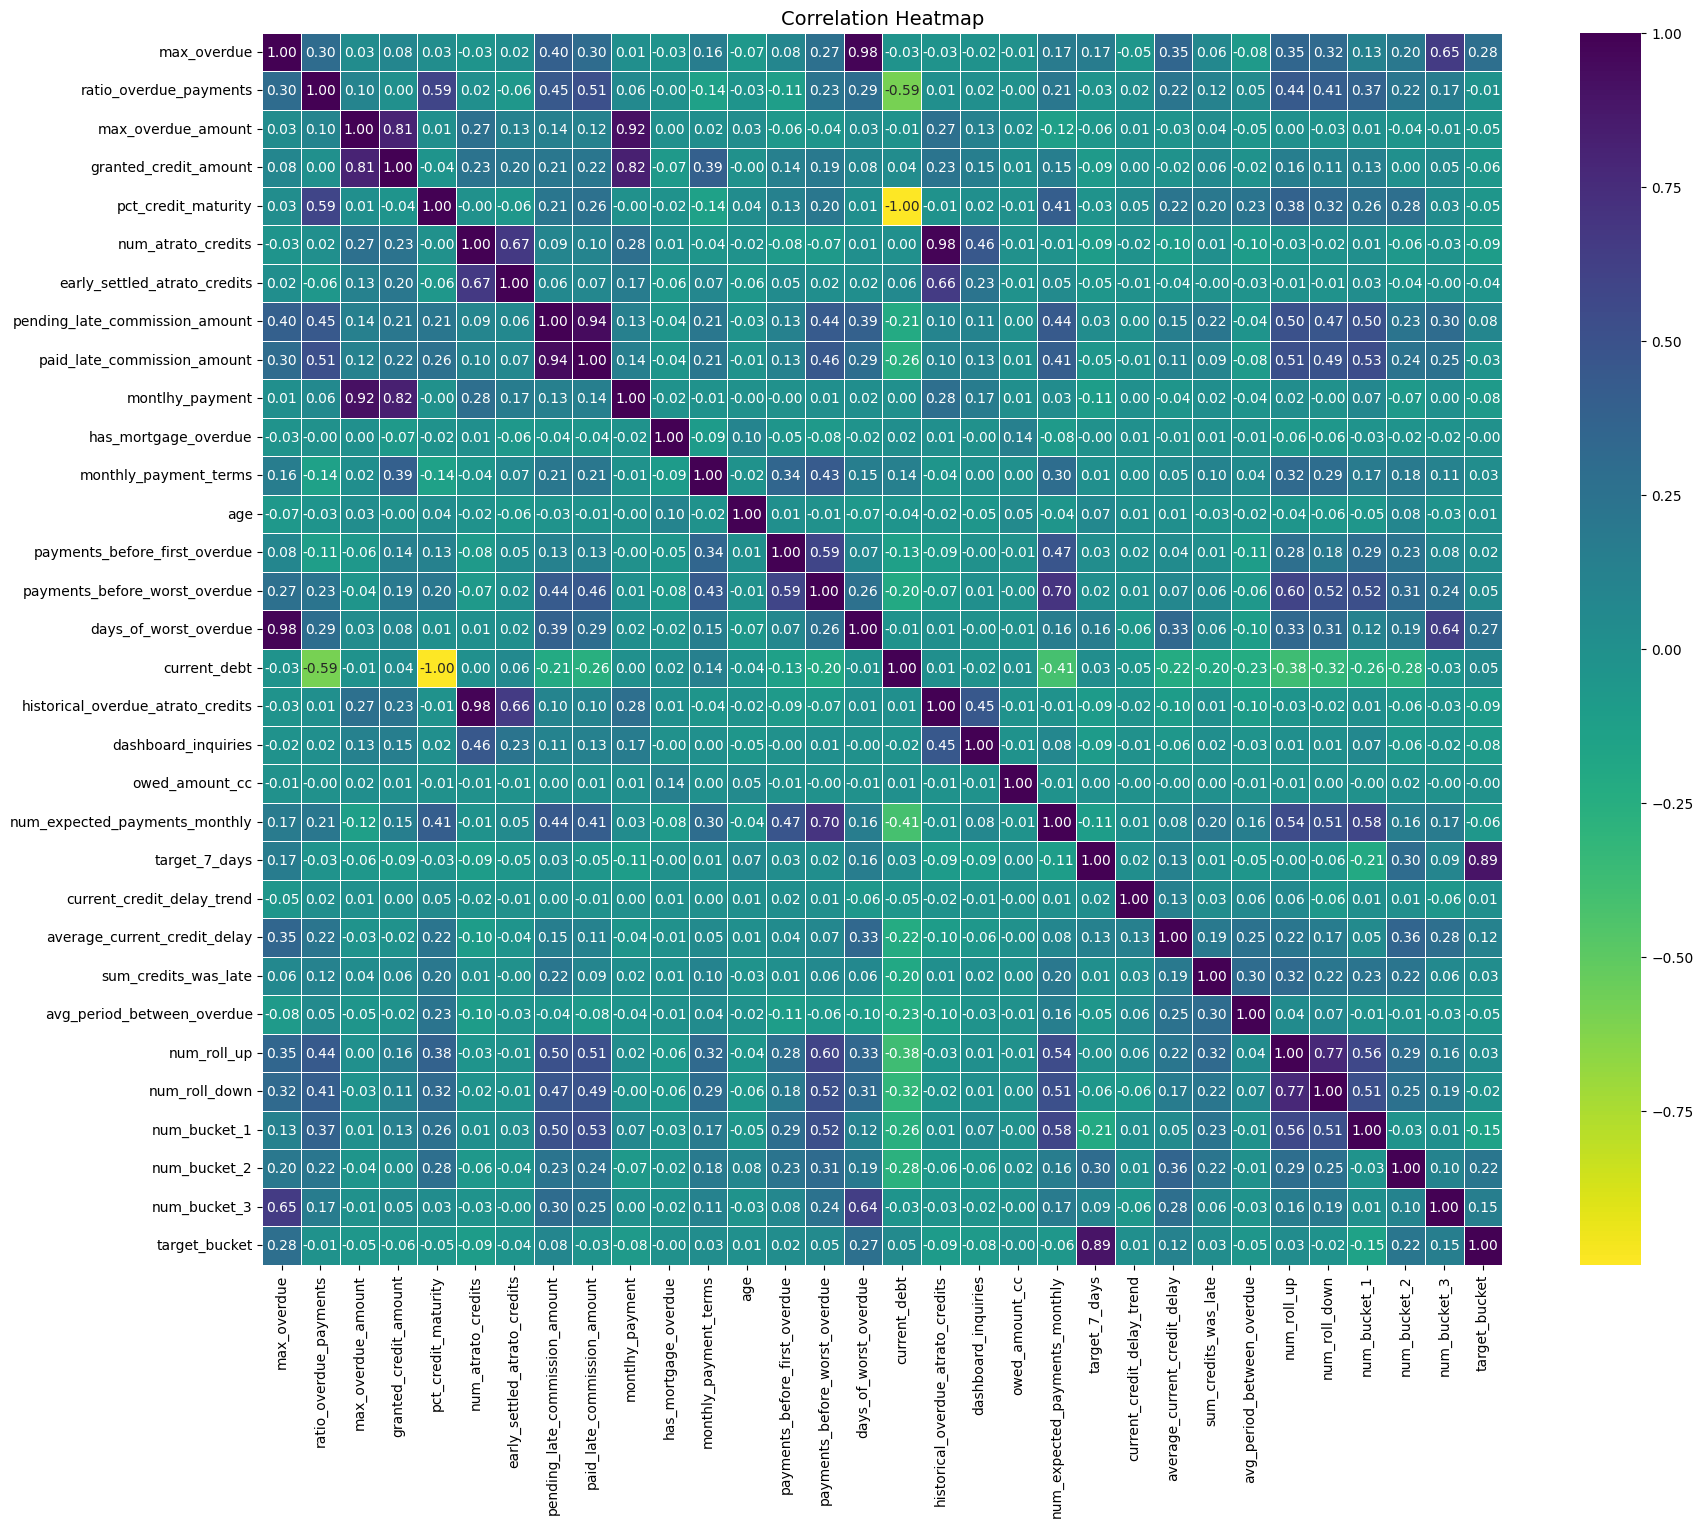

In [17]:
plt.figure(figsize=(20, 16))  
plt.title('Correlation Heatmap', fontsize=14)

sns.heatmap(df_corr.corr(), annot=True, 
            fmt=".2f",  # Limita a dos decimales
            cmap='viridis_r', linecolor='white', linewidths=0.5, 
            annot_kws={"size": 10}  # size font annot
            )

plt.xticks(rotation=90, fontsize=10) 
plt.yticks(fontsize=10)
plt.show()


***

## <font color='#8789ed' face='Tahoma' size=5>Análisis de <font color='#8789ed' face='Monaco' size=4>target_7_days y target_bucket</font> </font>

<font color='#b33b3b' face='Monaco' size=4>target_7_days</font> 

<font face='Arial' size=3>Revisar los valores y proporciones que tenemos en nuestro target</font>

- <font face='Arial' size=3>0: no entran a bucket 1 de cobranza</font>
- <font face='Arial' size=3>1: entran a bucket 1 de cobranza</font>





In [18]:
df['target_7_days'].value_counts(normalize=True)*100

target_7_days
1    53.216746
0    46.783254
Name: proportion, dtype: float64

In [19]:
df['target_7_days'].isnull().sum() / len(df)

0.0

<font color='#b33b3b' face='Monaco' size=4>target_bucket</font> 

<font face='Arial' size=3>Revisar los valores y proporciones que tenemos en nuestro target</font>

- <font face='Arial' size=3>0: no entran a bucket 1 de cobranza</font>
- <font face='Arial' size=3>1: entran a bucket 1 de cobranza</font>
- <font face='Arial' size=3>2: entran a bucket 2 de cobranza</font>

In [20]:
df['target_bucket'].value_counts(normalize=True)*100

target_bucket
0    46.783254
1    39.739929
2    13.476817
Name: proportion, dtype: float64

In [21]:
df['target_bucket'].isnull().sum() / len(df)

0.0

### <font color='#8789ed' face='Tahoma' size=5>Análisis de <font color='#8789ed' face='Monaco' size=4>payment_history</font>  vs. <font color='#8789ed' face='Monaco' size=4>target_7_days</font> </font>


<font color='#b33b3b' face='Monaco' size=4>payment_history</font> 

<font face='Arial' size=3>Revisión de los valores y proporciones en payment_history</font> 

<font face='Arial' size=3>Nos da un array con una serie de números, cada número indica cuántos días se atraso en ese pago. El total del conteo de número indica el total de número de pagos que ha hecho. Nos explica cuánto se ha atrasado o adelantado en cada pago.</font> 

- <font face='Arial' size=3>Números negativos indican que pagó antes de su fecha (pago anticipado)</font>
- <font face='Arial' size=3>Números positivos indican que pagó después de su fecha (pago atrasado)</font>


In [22]:
# conteo de nulos en dataframe completo
df['payment_history'].isnull().sum()

13934

In [23]:
# proporciíon de nulos en dataframe completo
(df['payment_history'].isnull().sum() / len(df))*100

10.810936627149152

In [24]:
# hacemos un df de solo los que tienen payment_hist nulo
null_pay_hist = df[(df['payment_history'].isna())]

# checamos los conteos en target (debería ser nulo ???)
null_pay_hist['target_7_days'].value_counts()

target_7_days
1    8030
0    5904
Name: count, dtype: int64

In [25]:
null_pay_hist[null_pay_hist['target_7_days'].isnull()]

,idobservation,id_solicitud,id_userv3,payment_history,max_overdue,ratio_overdue_payments,max_overdue_amount,granted_credit_amount,pct_credit_maturity,risk_profile_v1,risk_profile_v2,num_atrato_credits,early_settled_atrato_credits,pending_late_commission_amount,paid_late_commission_amount,montlhy_payment,has_mortgage_overdue,monthly_payment_terms,age,gender,payments_before_first_overdue,payments_before_worst_overdue,days_of_worst_overdue,has_mortgage_or_large_loans,current_debt,historical_overdue_atrato_credits,dashboard_inquiries,most_used_paymentmethod,owed_amount_cc,num_expected_payments_monthly,target_7_days,credito_created_at_utc,current_credit_delay_trend,average_current_credit_delay,sum_credits_was_late,avg_period_between_overdue,num_roll_up,num_roll_down,num_bucket_1,num_bucket_2,num_bucket_3,target_bucket


In [26]:
# conteo de nulos en dataframe completo
df['target_7_days'].isnull().sum()

0

<font face='Arial' size=3>No hay nulos en <font color='#b33b3b' face='Monaco' size=2>target_7_days</font>  

Las variables que salen de este análisis traen nulos cuando el payment history es nulo, se analizarán mediante bivariados para su correcto llenado, ya que estos créditos pueden caer en first payment default y es de interés segmentarlos correctamente.

In [27]:
df['credito_created_at_utc'][df['payment_history'].isna()]

21        2020-08-28 19:02:43.000
46        2020-12-02 15:12:40.000
51        2020-08-28 18:37:23.000
80        2020-08-28 18:50:21.000
81        2020-08-28 18:50:21.000
                   ...           
128882    2024-09-17 15:39:34.000
128883    2024-09-20 00:10:45.000
128885    2024-10-06 01:01:48.000
128886    2024-10-11 14:16:47.000
128887    2024-10-21 17:39:36.000
Name: credito_created_at_utc, Length: 13934, dtype: object

In [28]:
df[(df['payment_history'].isna())&(df['credito_created_at_utc']<'2021-03')].shape[0]/len(df[df['payment_history'].isna()])*100

0.6100186593942873

In [29]:
df[(df['payment_history'].isna())&(df['credito_created_at_utc']<'2021')]['target_7_days'].value_counts(normalize=True)

target_7_days
1    0.814286
0    0.185714
Name: proportion, dtype: float64

In [30]:
df[(df['payment_history'].isna())&(df['credito_created_at_utc']<'2022')&(df['credito_created_at_utc']>'2020')].shape[0]/len(df[df['payment_history'].isna()])*100

6.186306875269126

In [31]:
df[(df['payment_history'].isna())&(df['credito_created_at_utc']<'2022')&(df['credito_created_at_utc']>'2020')].describe()

,id_solicitud,id_userv3,max_overdue,ratio_overdue_payments,max_overdue_amount,granted_credit_amount,pct_credit_maturity,num_atrato_credits,early_settled_atrato_credits,pending_late_commission_amount,paid_late_commission_amount,montlhy_payment,has_mortgage_overdue,monthly_payment_terms,age,payments_before_first_overdue,payments_before_worst_overdue,days_of_worst_overdue,has_mortgage_or_large_loans,current_debt,historical_overdue_atrato_credits,dashboard_inquiries,owed_amount_cc,num_expected_payments_monthly,target_7_days,current_credit_delay_trend,average_current_credit_delay,sum_credits_was_late,avg_period_between_overdue,num_roll_up,num_roll_down,num_bucket_1,num_bucket_2,num_bucket_3,target_bucket
count,862.000000,862.000000,83.000000,83.000000,83.000000,862.000000,214.000000,862.000000,16.0000,12.000000,6.0,862.000000,97.00000,862.000000,862.000000,83.000000,83.000000,83.000000,97.0,214.000000,86.000000,0.0,841.000000,862.000000,862.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,862.000000
mean,85004.603248,26654.983759,14.602410,0.113337,1152.607229,10528.150302,0.092346,1.105568,1.0625,187.500000,150.0,1374.109799,0.14433,10.676334,33.199536,2.554217,2.987952,14.698795,1.0,0.907696,1.034884,NaN,5553.187872,2.287703,0.641531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.989559
std,48779.533749,23094.591883,33.278184,0.072677,911.753981,10310.309417,0.093590,0.318594,0.2500,93.237234,0.0,1371.929862,0.35325,5.515967,10.794226,3.041393,3.423356,33.246946,0.0,0.093568,0.184561,NaN,15378.465033,3.930383,0.479829,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.840957
min,3071.000000,34.000000,1.000000,0.025000,200.000000,1000.000000,0.000000,1.000000,1.0000,150.000000,150.0,79.190000,0.00000,1.000000,18.000000,0.000000,0.000000,1.000000,1.0,-0.000000,1.000000,NaN,0.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,43454.500000,6944.000000,2.000000,0.067000,600.000000,4262.750000,0.047000,1.000000,1.0000,150.000000,150.0,651.215000,0.00000,6.000000,25.000000,0.000000,0.000000,2.000000,1.0,0.892250,1.000000,NaN,0.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
50%,82779.500000,17101.500000,4.000000,0.083000,893.000000,7000.000000,0.066000,1.000000,1.0000,150.000000,150.0,1025.880000,0.00000,9.000000,31.000000,1.000000,1.000000,4.000000,1.0,0.934000,1.000000,NaN,0.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
75%,131666.000000,48609.500000,8.000000,0.139000,1351.000000,14452.250000,0.107750,1.000000,1.0000,150.000000,150.0,1651.990000,0.00000,12.000000,38.000000,5.000000,6.000000,8.000000,1.0,0.953000,1.000000,NaN,4033.000000,2.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000
max,175813.000000,77497.000000,170.000000,0.333000,5000.000000,85000.000000,1.000000,3.000000,2.0000,450.000000,150.0,22645.430000,1.00000,40.000000,70.000000,10.000000,13.000000,170.000000,1.0,1.000000,2.000000,NaN,124798.000000,44.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000


***

## <font color='#8789ed' face='Tahoma' size=5>Exploración de variables</font> 

<font face='Arial' size=3>Es importante tomar en cuenta que por ahora se pueden hacer dos aproximaciones:</font> 

1. <font face='Arial' size=3>Cada registro que entre al entrenamiento corresponde a un usuario.</font> 
2. <font face='Arial' size=3>Cada registro que entra al entrenamiento corresponde a un crédito.</font> 


In [32]:
len(df)

128888

In [33]:
# hacemos un df de solo los que tienen payment_hist con valor
#df = df[~(df['payment_history'].isna())]
len(df)


128888

In [34]:
df['target_7_days'].value_counts()

target_7_days
1    68590
0    60298
Name: count, dtype: int64

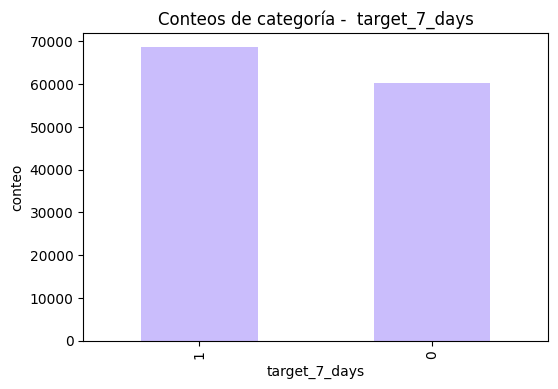

In [35]:
plt.figure(figsize=(6, 4))
df['target_7_days'].value_counts().plot(kind='bar' , color='#cabdfc')
plt.title(f'Conteos de categoría -  {'target_7_days'}')
plt.xlabel('target_7_days')
plt.ylabel('conteo')
plt.xticks(rotation=90)
plt.show()

In [36]:
# id_userv3 es el usuario que llega a hacer solicitud (un solo user puede tener varios idsolicitud)
df['id_userv3'].unique().shape

(33006,)

In [37]:
df['num_atrato_credits'].value_counts()

num_atrato_credits
1.0     71790
2.0     30926
3.0     15117
4.0      6487
5.0      2822
6.0      1029
7.0       403
8.0       190
9.0        38
10.0       34
11.0        4
12.0        3
15.0        2
17.0        2
Name: count, dtype: int64

In [38]:
# 2 usuarios tienen hasta 17 créditos
df[df['num_atrato_credits']==17]

,idobservation,id_solicitud,id_userv3,payment_history,max_overdue,ratio_overdue_payments,max_overdue_amount,granted_credit_amount,pct_credit_maturity,risk_profile_v1,risk_profile_v2,num_atrato_credits,early_settled_atrato_credits,pending_late_commission_amount,paid_late_commission_amount,montlhy_payment,has_mortgage_overdue,monthly_payment_terms,age,gender,payments_before_first_overdue,payments_before_worst_overdue,days_of_worst_overdue,has_mortgage_or_large_loans,current_debt,historical_overdue_atrato_credits,dashboard_inquiries,most_used_paymentmethod,owed_amount_cc,num_expected_payments_monthly,target_7_days,credito_created_at_utc,current_credit_delay_trend,average_current_credit_delay,sum_credits_was_late,avg_period_between_overdue,num_roll_up,num_roll_down,num_bucket_1,num_bucket_2,num_bucket_3,target_bucket
112810,1697742-5,1697742,2426,"16,-7,0,17",16.0,0.333,2536.52,11000.0,0.704,B1,B1,17.0,14.0,300.0,300.0,2236.52,NaN,6,35,Hombre,0.0,8.0,16.0,NaN,0.296,17.0,521.0,BBVA Practicaja,0.0,5,0,2024-06-16 00:39:20.000,-5.666667,2.833333,1.0,0.50,1.0,1.0,2.0,0.0,0.0,0
112811,1697742-4,1697742,2426,"-7,0,17",1.0,0.167,2231.39,11000.0,0.529,B1,B1,17.0,14.0,300.0,NaN,2236.52,NaN,6,35,Hombre,1.0,1.0,2.0,NaN,0.471,17.0,512.0,NaN,0.0,4,0,2024-06-16 00:39:20.000,0.000000,0.000000,1.0,0.25,0.0,1.0,1.0,0.0,0.0,0


In [39]:
df

,idobservation,id_solicitud,id_userv3,payment_history,max_overdue,ratio_overdue_payments,max_overdue_amount,granted_credit_amount,pct_credit_maturity,risk_profile_v1,risk_profile_v2,num_atrato_credits,early_settled_atrato_credits,pending_late_commission_amount,paid_late_commission_amount,montlhy_payment,has_mortgage_overdue,monthly_payment_terms,age,gender,payments_before_first_overdue,payments_before_worst_overdue,days_of_worst_overdue,has_mortgage_or_large_loans,current_debt,historical_overdue_atrato_credits,dashboard_inquiries,most_used_paymentmethod,owed_amount_cc,num_expected_payments_monthly,target_7_days,credito_created_at_utc,current_credit_delay_trend,average_current_credit_delay,sum_credits_was_late,avg_period_between_overdue,num_roll_up,num_roll_down,num_bucket_1,num_bucket_2,num_bucket_3,target_bucket
0,3187-15,3187,6117,"-26,-33,-29,-32,-30,0",NaN,NaN,NaN,15000.00,0.305,NaN,NaN,1.0,NaN,NaN,NaN,1344.717480,NaN,18,41,Hombre,NaN,NaN,NaN,NaN,0.695,1.0,NaN,NaN,0.0,15,1,2020-08-28 18:38:56.000,-3.000000,-21.666667,0.0,0.000,0.0,0.0,0.0,0.0,0.0,2
1,4557-11,4557,6146,"3,3,0,1,0,2,0",3.0,0.222,3428.98000,40000.00,0.374,NaN,NaN,1.0,NaN,NaN,NaN,3428.981610,0.0,18,46,Hombre,6.0,26.0,3.0,1.0,0.626,1.0,NaN,NaN,0.0,11,1,2020-08-28 18:51:18.000,2.000000,2.333333,1.0,1.250,0.0,0.0,0.0,0.0,0.0,1
2,4557-10,4557,6146,"3,3,0,1,0,2,0",3.0,0.222,3428.98000,40000.00,0.374,NaN,NaN,1.0,NaN,NaN,NaN,3428.981610,0.0,18,46,Hombre,7.0,32.0,3.0,1.0,0.626,1.0,NaN,NaN,0.0,10,1,2020-08-28 18:51:18.000,1.000000,1.166667,1.0,0.625,0.0,0.0,0.0,0.0,0.0,1
3,4557-12,4557,6146,"35,44,3,3,0,1,0,2,0",14.0,0.333,3577.99839,40000.00,0.493,NaN,NaN,1.0,NaN,150.0,150.0,3428.981610,0.0,18,46,Hombre,8.0,41.0,14.0,1.0,0.507,1.0,NaN,NaN,0.0,12,1,2020-08-28 18:51:18.000,0.666667,4.166667,1.0,0.390,1.0,0.0,0.0,2.0,0.0,1
4,6617-8,6617,6167,"0,-2,0,0,0",NaN,NaN,NaN,7000.00,0.535,C1,NaN,1.0,NaN,NaN,NaN,927.488565,NaN,9,24,Hombre,NaN,NaN,NaN,NaN,0.465,1.0,NaN,BBVA Practicaja,0.0,8,1,2020-08-28 18:59:15.000,0.000000,0.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128883,1839553-1,1839553,677677,NaN,NaN,NaN,NaN,9965.51,NaN,B1,B1,1.0,NaN,300.0,NaN,1707.550000,0.0,9,43,Hombre,NaN,NaN,NaN,1.0,NaN,NaN,4.0,NaN,31283.0,1,0,2024-09-20 00:10:45.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
128884,1848484-2,1848484,681316,0,NaN,NaN,NaN,3899.00,0.057,C3,C2,1.0,NaN,NaN,NaN,479.780000,NaN,12,38,Hombre,NaN,NaN,NaN,NaN,0.943,1.0,8.0,PayAnywhere,1397.0,2,0,2024-09-22 22:49:39.000,0.000000,0.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0
128885,1863038-1,1863038,686747,NaN,NaN,NaN,NaN,8000.00,0.051,A3,B2,1.0,NaN,NaN,NaN,1100.370000,NaN,12,41,Hombre,NaN,NaN,NaN,NaN,0.950,NaN,18.0,OxxoPay,0.0,1,1,2024-10-06 01:01:48.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
128886,1881777-1,1881777,105450,NaN,NaN,NaN,NaN,11200.00,0.000,C2,A1,3.0,2.0,300.0,NaN,1197.420000,NaN,24,42,Hombre,NaN,NaN,NaN,NaN,1.000,2.0,121.0,OxxoPay,189.0,1,0,2024-10-11 14:16:47.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [40]:
features_list = list(df.columns)
features_list.remove('id_solicitud')
features_list.remove('id_userv3')
features_list.remove('idobservation')
features_list.remove('target_7_days')
features_list.remove('credito_created_at_utc')
features_list.remove('target_bucket')
features_list

['payment_history',
 'max_overdue',
 'ratio_overdue_payments',
 'max_overdue_amount',
 'granted_credit_amount',
 'pct_credit_maturity',
 'risk_profile_v1',
 'risk_profile_v2',
 'num_atrato_credits',
 'early_settled_atrato_credits',
 'pending_late_commission_amount',
 'paid_late_commission_amount',
 'montlhy_payment',
 'has_mortgage_overdue',
 'monthly_payment_terms',
 'age',
 'gender',
 'payments_before_first_overdue',
 'payments_before_worst_overdue',
 'days_of_worst_overdue',
 'has_mortgage_or_large_loans',
 'current_debt',
 'historical_overdue_atrato_credits',
 'dashboard_inquiries',
 'most_used_paymentmethod',
 'owed_amount_cc',
 'num_expected_payments_monthly',
 'current_credit_delay_trend',
 'average_current_credit_delay',
 'sum_credits_was_late',
 'avg_period_between_overdue',
 'num_roll_up',
 'num_roll_down',
 'num_bucket_1',
 'num_bucket_2',
 'num_bucket_3']

In [41]:
len(features_list)

36

***
## <font color='#78acf0' face='Optima' size=5>Numeric Features</font> 

<font face='Arial' size=3>Establecemos una lista de las features numéricas para analizarlas en conjunto en la generalidad e ir revisando a detalle cada una. Este nuevo dataset nos permite generar gráficas usando una función y así observar qué variables pueden ser conflictivas.</font> 




In [42]:
df

,idobservation,id_solicitud,id_userv3,payment_history,max_overdue,ratio_overdue_payments,max_overdue_amount,granted_credit_amount,pct_credit_maturity,risk_profile_v1,risk_profile_v2,num_atrato_credits,early_settled_atrato_credits,pending_late_commission_amount,paid_late_commission_amount,montlhy_payment,has_mortgage_overdue,monthly_payment_terms,age,gender,payments_before_first_overdue,payments_before_worst_overdue,days_of_worst_overdue,has_mortgage_or_large_loans,current_debt,historical_overdue_atrato_credits,dashboard_inquiries,most_used_paymentmethod,owed_amount_cc,num_expected_payments_monthly,target_7_days,credito_created_at_utc,current_credit_delay_trend,average_current_credit_delay,sum_credits_was_late,avg_period_between_overdue,num_roll_up,num_roll_down,num_bucket_1,num_bucket_2,num_bucket_3,target_bucket
0,3187-15,3187,6117,"-26,-33,-29,-32,-30,0",NaN,NaN,NaN,15000.00,0.305,NaN,NaN,1.0,NaN,NaN,NaN,1344.717480,NaN,18,41,Hombre,NaN,NaN,NaN,NaN,0.695,1.0,NaN,NaN,0.0,15,1,2020-08-28 18:38:56.000,-3.000000,-21.666667,0.0,0.000,0.0,0.0,0.0,0.0,0.0,2
1,4557-11,4557,6146,"3,3,0,1,0,2,0",3.0,0.222,3428.98000,40000.00,0.374,NaN,NaN,1.0,NaN,NaN,NaN,3428.981610,0.0,18,46,Hombre,6.0,26.0,3.0,1.0,0.626,1.0,NaN,NaN,0.0,11,1,2020-08-28 18:51:18.000,2.000000,2.333333,1.0,1.250,0.0,0.0,0.0,0.0,0.0,1
2,4557-10,4557,6146,"3,3,0,1,0,2,0",3.0,0.222,3428.98000,40000.00,0.374,NaN,NaN,1.0,NaN,NaN,NaN,3428.981610,0.0,18,46,Hombre,7.0,32.0,3.0,1.0,0.626,1.0,NaN,NaN,0.0,10,1,2020-08-28 18:51:18.000,1.000000,1.166667,1.0,0.625,0.0,0.0,0.0,0.0,0.0,1
3,4557-12,4557,6146,"35,44,3,3,0,1,0,2,0",14.0,0.333,3577.99839,40000.00,0.493,NaN,NaN,1.0,NaN,150.0,150.0,3428.981610,0.0,18,46,Hombre,8.0,41.0,14.0,1.0,0.507,1.0,NaN,NaN,0.0,12,1,2020-08-28 18:51:18.000,0.666667,4.166667,1.0,0.390,1.0,0.0,0.0,2.0,0.0,1
4,6617-8,6617,6167,"0,-2,0,0,0",NaN,NaN,NaN,7000.00,0.535,C1,NaN,1.0,NaN,NaN,NaN,927.488565,NaN,9,24,Hombre,NaN,NaN,NaN,NaN,0.465,1.0,NaN,BBVA Practicaja,0.0,8,1,2020-08-28 18:59:15.000,0.000000,0.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128883,1839553-1,1839553,677677,NaN,NaN,NaN,NaN,9965.51,NaN,B1,B1,1.0,NaN,300.0,NaN,1707.550000,0.0,9,43,Hombre,NaN,NaN,NaN,1.0,NaN,NaN,4.0,NaN,31283.0,1,0,2024-09-20 00:10:45.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
128884,1848484-2,1848484,681316,0,NaN,NaN,NaN,3899.00,0.057,C3,C2,1.0,NaN,NaN,NaN,479.780000,NaN,12,38,Hombre,NaN,NaN,NaN,NaN,0.943,1.0,8.0,PayAnywhere,1397.0,2,0,2024-09-22 22:49:39.000,0.000000,0.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0
128885,1863038-1,1863038,686747,NaN,NaN,NaN,NaN,8000.00,0.051,A3,B2,1.0,NaN,NaN,NaN,1100.370000,NaN,12,41,Hombre,NaN,NaN,NaN,NaN,0.950,NaN,18.0,OxxoPay,0.0,1,1,2024-10-06 01:01:48.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
128886,1881777-1,1881777,105450,NaN,NaN,NaN,NaN,11200.00,0.000,C2,A1,3.0,2.0,300.0,NaN,1197.420000,NaN,24,42,Hombre,NaN,NaN,NaN,NaN,1.000,2.0,121.0,OxxoPay,189.0,1,0,2024-10-11 14:16:47.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [43]:
numeric_features = ['max_overdue','ratio_overdue_payments','max_overdue_amount','granted_credit_amount','pct_credit_maturity', 'num_atrato_credits','early_settled_atrato_credits',
                    'pending_late_commission_amount','paid_late_commission_amount','montlhy_payment','monthly_payment_terms','age','payments_before_first_overdue',
                    'payments_before_worst_overdue','days_of_worst_overdue','current_debt','historical_overdue_atrato_credits','dashboard_inquiries',
                    'owed_amount_cc','num_expected_payments_monthly','current_credit_delay_trend','average_current_credit_delay','sum_credits_was_late','avg_period_between_overdue',
                    'num_roll_up','num_roll_down','num_bucket_1','num_bucket_2','num_bucket_3']

numeric_features

['max_overdue',
 'ratio_overdue_payments',
 'max_overdue_amount',
 'granted_credit_amount',
 'pct_credit_maturity',
 'num_atrato_credits',
 'early_settled_atrato_credits',
 'pending_late_commission_amount',
 'paid_late_commission_amount',
 'montlhy_payment',
 'monthly_payment_terms',
 'age',
 'payments_before_first_overdue',
 'payments_before_worst_overdue',
 'days_of_worst_overdue',
 'current_debt',
 'historical_overdue_atrato_credits',
 'dashboard_inquiries',
 'owed_amount_cc',
 'num_expected_payments_monthly',
 'current_credit_delay_trend',
 'average_current_credit_delay',
 'sum_credits_was_late',
 'avg_period_between_overdue',
 'num_roll_up',
 'num_roll_down',
 'num_bucket_1',
 'num_bucket_2',
 'num_bucket_3']

In [44]:
len(numeric_features)

29

In [45]:
df_numeric = df[numeric_features]
df_numeric


,max_overdue,ratio_overdue_payments,max_overdue_amount,granted_credit_amount,pct_credit_maturity,num_atrato_credits,early_settled_atrato_credits,pending_late_commission_amount,paid_late_commission_amount,montlhy_payment,monthly_payment_terms,age,payments_before_first_overdue,payments_before_worst_overdue,days_of_worst_overdue,current_debt,historical_overdue_atrato_credits,dashboard_inquiries,owed_amount_cc,num_expected_payments_monthly,current_credit_delay_trend,average_current_credit_delay,sum_credits_was_late,avg_period_between_overdue,num_roll_up,num_roll_down,num_bucket_1,num_bucket_2,num_bucket_3
0,NaN,NaN,NaN,15000.00,0.305,1.0,NaN,NaN,NaN,1344.717480,18,41,NaN,NaN,NaN,0.695,1.0,NaN,0.0,15,-3.000000,-21.666667,0.0,0.000,0.0,0.0,0.0,0.0,0.0
1,3.0,0.222,3428.98000,40000.00,0.374,1.0,NaN,NaN,NaN,3428.981610,18,46,6.0,26.0,3.0,0.626,1.0,NaN,0.0,11,2.000000,2.333333,1.0,1.250,0.0,0.0,0.0,0.0,0.0
2,3.0,0.222,3428.98000,40000.00,0.374,1.0,NaN,NaN,NaN,3428.981610,18,46,7.0,32.0,3.0,0.626,1.0,NaN,0.0,10,1.000000,1.166667,1.0,0.625,0.0,0.0,0.0,0.0,0.0
3,14.0,0.333,3577.99839,40000.00,0.493,1.0,NaN,150.0,150.0,3428.981610,18,46,8.0,41.0,14.0,0.507,1.0,NaN,0.0,12,0.666667,4.166667,1.0,0.390,1.0,0.0,0.0,2.0,0.0
4,NaN,NaN,NaN,7000.00,0.535,1.0,NaN,NaN,NaN,927.488565,9,24,NaN,NaN,NaN,0.465,1.0,NaN,0.0,8,0.000000,0.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128883,NaN,NaN,NaN,9965.51,NaN,1.0,NaN,300.0,NaN,1707.550000,9,43,NaN,NaN,NaN,NaN,NaN,4.0,31283.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
128884,NaN,NaN,NaN,3899.00,0.057,1.0,NaN,NaN,NaN,479.780000,12,38,NaN,NaN,NaN,0.943,1.0,8.0,1397.0,2,0.000000,0.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.0
128885,NaN,NaN,NaN,8000.00,0.051,1.0,NaN,NaN,NaN,1100.370000,12,41,NaN,NaN,NaN,0.950,NaN,18.0,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
128886,NaN,NaN,NaN,11200.00,0.000,3.0,2.0,300.0,NaN,1197.420000,24,42,NaN,NaN,NaN,1.000,2.0,121.0,189.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### <font color='sky blue' face='Optima' size=4>Correlation Chart</font> 


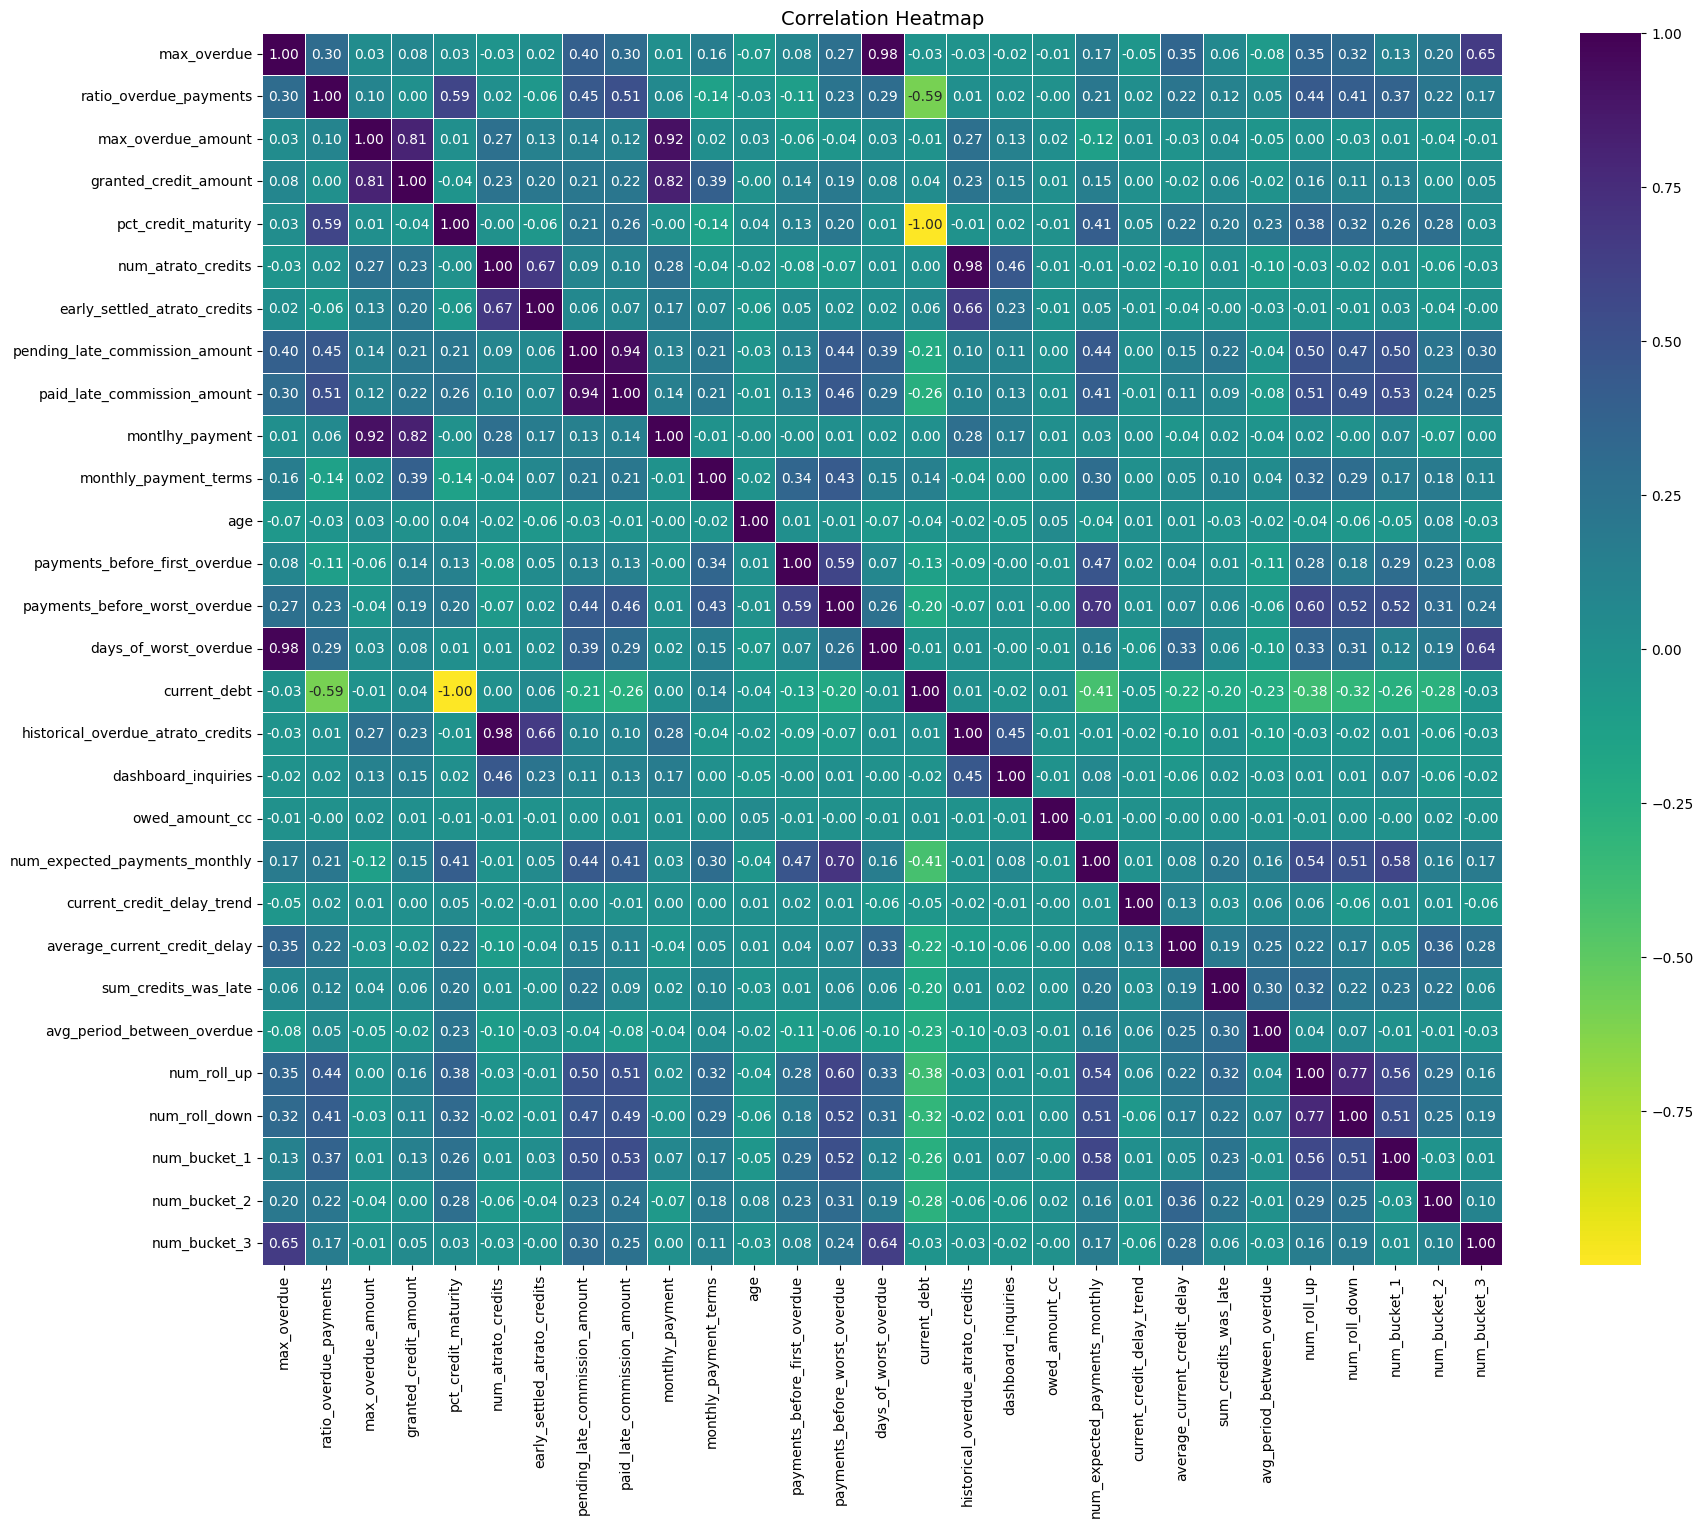

In [46]:
plt.figure(figsize=(20, 16))  
plt.title('Correlation Heatmap', fontsize=14)

sns.heatmap(df_numeric.corr(), annot=True, 
            fmt=".2f",  # 2 decimales
            cmap='viridis_r', linecolor='white', linewidths=0.5, 
            annot_kws={"size": 10}  # size font annot
            )

plt.xticks(rotation=90, fontsize=10) 
plt.yticks(fontsize=10)
plt.show()

### <font color='sky blue' face='Optima' size=4>Numeric Cols Null Volume</font> 


In [47]:
get_missing_report(df_numeric)

,columns,missingPercentage,type
6,early_settled_atrato_credits,85.087052,float64
8,paid_late_commission_amount,49.205512,float64
7,pending_late_commission_amount,33.830147,float64
0,max_overdue,28.578301,float64
1,ratio_overdue_payments,28.578301,float64
14,days_of_worst_overdue,28.578301,float64
12,payments_before_first_overdue,28.551921,float64
13,payments_before_worst_overdue,28.551921,float64
2,max_overdue_amount,28.551921,float64
17,dashboard_inquiries,24.093011,float64


### <font color='sky blue' face='Optima' size=4>Numeric Cols Distribution</font> 


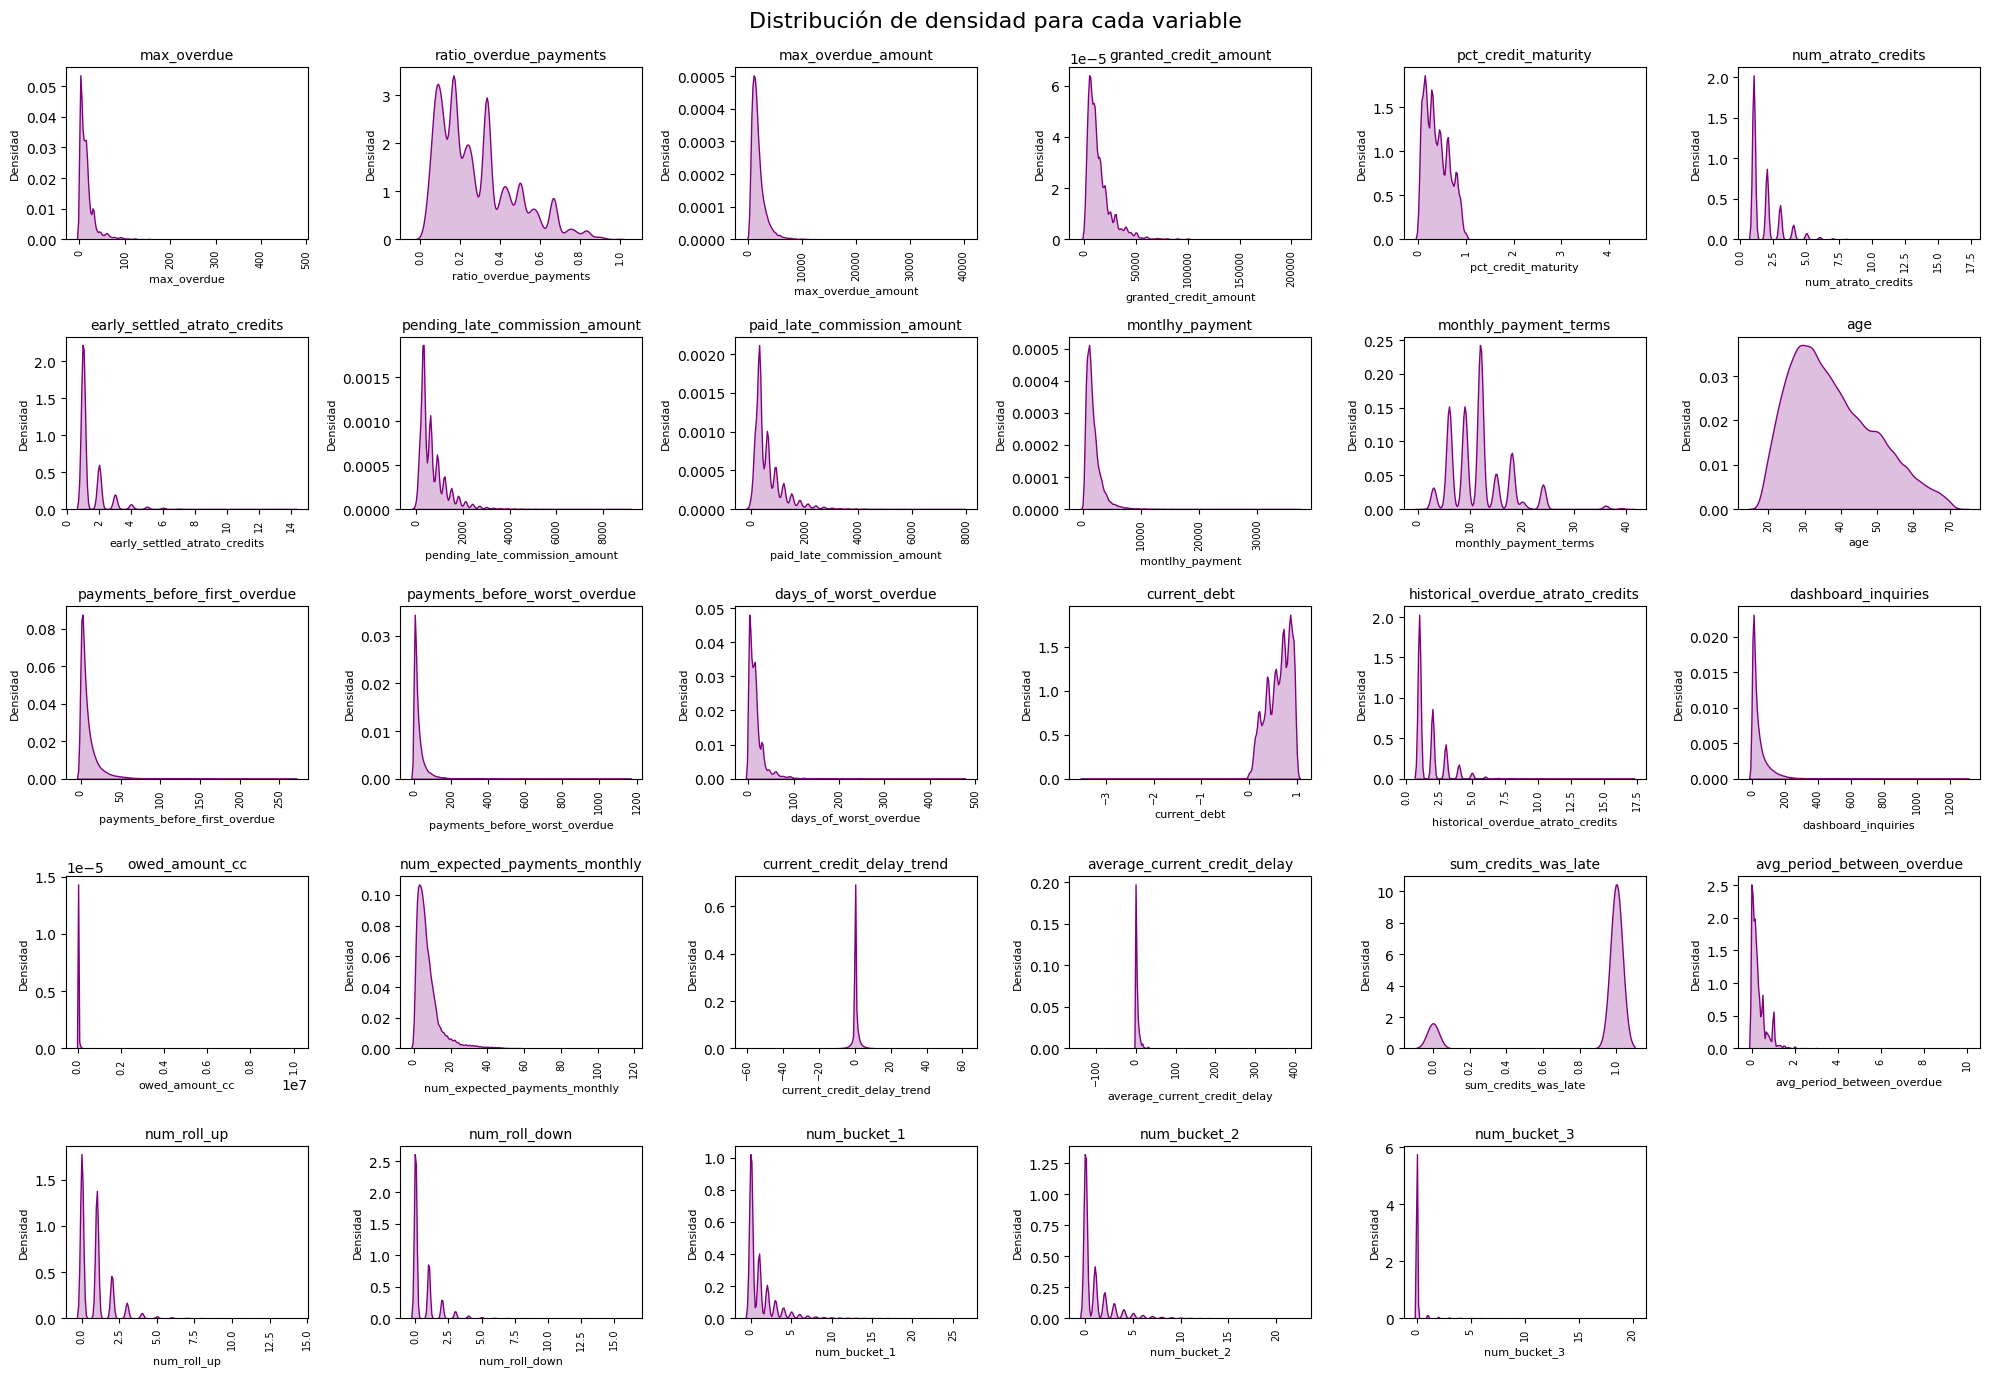

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

n_cols = 6
n_rows = 5

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 14)) 
fig.suptitle('Distribución de densidad para cada variable', fontsize=16)
axes = axes.flatten() 
for i, col in enumerate(df_numeric.columns):
    sns.kdeplot(data=df_numeric, x=col, color='purple', fill=True, ax=axes[i])
    axes[i].set_title(f'{col}', fontsize=10)
    axes[i].set_xlabel(col, fontsize=8)
    axes[i].set_ylabel('Densidad', fontsize=8)
    axes[i].tick_params(axis='x', rotation=90, labelsize=7)

# Oculta cualquier subfigura vacía 
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


#### <font color='#b33b3b' face='Monaco' size=5>max_overdue</font> 

<font face='Arial' size=3>Máximo número de días atrasado (actual crédito)</font> 

<font face='Arial' size=3>Los montos negativos representan que pagó ese número de días antes de su fecha</font> 



In [49]:
df_numeric['max_overdue'].describe()

count    92054.000000
mean        15.966324
std         20.615340
min          1.000000
25%          3.000000
50%         11.000000
75%         19.000000
max        473.000000
Name: max_overdue, dtype: float64

In [50]:
len(df_numeric[df_numeric['max_overdue']<1])/len(df_numeric)*100

0.0

In [51]:
# iqr para determinar 'normalidad'
IQR = df_numeric['max_overdue'].describe()[6]-df_numeric['max_overdue'].describe()[4]
rango = [df_numeric['max_overdue'].describe()[4]-IQR*1.5, df_numeric['max_overdue'].describe()[6]+IQR*1.5]
print(rango)

[-21.0, 43.0]


/tmp/ipykernel_1343/1354835366.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['max_overdue'].describe()[6]-df_numeric['max_overdue'].describe()[4]
/tmp/ipykernel_1343/1354835366.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['max_overdue'].describe()[6]-df_numeric['max_overdue'].describe()[4]
/tmp/ipykernel_1343/1354835366.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rango = [df_num

<font face='Arial' size=3>Consideramos normal de -9 a 15 días de atraso</font> 

<font face='Arial' size=3>Revisión de atrasados más de 15 dias</font> 



In [52]:
# cantidad de registros con atraso mayor a 15 dias
len(df_numeric[df_numeric['max_overdue']>15])

30356

In [53]:
# proporción de registros con atraso mayor a 15 dias
len(df_numeric[df_numeric['max_overdue']>15]) / len(df_numeric)*100

23.552231394699273

In [54]:
# media de días de atraso en mayor a 15 dias
df_numeric[df_numeric['max_overdue']>15]['max_overdue'].mean()

35.23138753458954

In [55]:
# máximo de días de atraso en mayor a 15 dias
df_numeric[df_numeric['max_overdue']>15]['max_overdue'].max()

473.0

In [56]:
# mínimo de días de atraso en mayor a 15 dias
df_numeric[df_numeric['max_overdue']>15]['max_overdue'].min()

16.0

In [57]:
df_numeric[df_numeric['max_overdue']>15]['max_overdue'].describe()

count    30356.000000
mean        35.231388
std         26.259458
min         16.000000
25%         19.000000
50%         27.000000
75%         39.000000
max        473.000000
Name: max_overdue, dtype: float64

In [58]:
len(df_numeric[df_numeric['max_overdue']>81])

1865

In [59]:
len(df_numeric[df_numeric['max_overdue']>81])/len(df_numeric)*100

1.4469927378809508

<font face='Arial' size=3>Revisión de atrasados menos de -9 dias</font> 


In [60]:
# cantidad de registros con anticipación mayor a 9 dias
len(df_numeric[df_numeric['max_overdue']<-9])

0

In [61]:
# proporción de registros con anticipación mayor a 9 dias
len(df_numeric[df_numeric['max_overdue']<-9]) / len(df_numeric) *100

0.0

In [62]:
# media de días de anticipación mayor a 9 dias
df_numeric[df_numeric['max_overdue']<-9]['max_overdue'].mean()

nan

In [63]:
# mínimo de días de anticipación mayor a 9 dias
df_numeric[df_numeric['max_overdue']<-9]['max_overdue'].max()

nan

In [64]:
# máximo de días de anticipación mayor a 9 dias
df_numeric[df_numeric['max_overdue']<-9]['max_overdue'].min()

nan

In [65]:
df_numeric[df_numeric['max_overdue']<-9]['max_overdue'].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: max_overdue, dtype: float64

In [66]:
len(df_numeric[df_numeric['max_overdue']<-23])

0

In [67]:
len(df_numeric[df_numeric['max_overdue']<-23])/len(df_numeric)*100

0.0

#### <font color='#b33b3b' face='Monaco' size=5>days_of_worst_overdue</font> 

<font face='Arial' size=3>Número de días de su peor atraso (de este crédito para atrás, incluye crédito actual pero no última parcialidad pagada)</font> 

<font face='Arial' size=3>Winner vs. max_overdue</font> 


<font face='Arial' size=3>Los montos negativos representan que pagó ese número de días antes de su fecha</font> 



In [68]:
df_numeric['days_of_worst_overdue'].describe()

count    92054.000000
mean        16.780335
std         20.787258
min          1.000000
25%          4.000000
50%         11.000000
75%         20.000000
max        473.000000
Name: days_of_worst_overdue, dtype: float64

In [69]:
len(df_numeric[df_numeric['days_of_worst_overdue']<1])/len(df_numeric)*100

0.0

In [70]:
# iqr para determinar 'normalidad'
IQR = df_numeric['days_of_worst_overdue'].describe()[6]-df_numeric['days_of_worst_overdue'].describe()[4]
rango = [df_numeric['days_of_worst_overdue'].describe()[4]-IQR*1.5, df_numeric['days_of_worst_overdue'].describe()[6]+IQR*1.5]
print(rango)

[-20.0, 44.0]


/tmp/ipykernel_1343/3668458543.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['days_of_worst_overdue'].describe()[6]-df_numeric['days_of_worst_overdue'].describe()[4]
/tmp/ipykernel_1343/3668458543.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['days_of_worst_overdue'].describe()[6]-df_numeric['days_of_worst_overdue'].describe()[4]
/tmp/ipykernel_1343/3668458543.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by positio

<font face='Arial' size=3>Consideramos normal de 1 (minimo) a 44 días del peor atraso</font> 

<font face='Arial' size=3>Revisión de atrasos máximos de más de 44 dias</font> 



In [71]:
# cantidad de registros con atraso máximo mayor a 44 dias
len(df_numeric[df_numeric['days_of_worst_overdue']>44])

6824

In [72]:
# proporción de registros con atraso máximo mayor a 44 dias
len(df_numeric[df_numeric['days_of_worst_overdue']>44]) / len(df_numeric)*100

5.294519272546707

In [73]:
# media de días de atraso máximo mayor a 44 dias
df_numeric[df_numeric['days_of_worst_overdue']>44]['days_of_worst_overdue'].mean()

74.29542790152404

In [74]:
# máximo de días de atraso máximo mayor a 44 dias
df_numeric[df_numeric['days_of_worst_overdue']>44]['days_of_worst_overdue'].max()

473.0

In [75]:
# mínimo de días de atraso máximo mayor a 44 dias
df_numeric[df_numeric['days_of_worst_overdue']>44]['days_of_worst_overdue'].min()

45.0

In [76]:
df_numeric[df_numeric['days_of_worst_overdue']>44]['days_of_worst_overdue'].describe()

count    6824.000000
mean       74.295428
std        31.917554
min        45.000000
25%        55.000000
50%        63.000000
75%        86.000000
max       473.000000
Name: days_of_worst_overdue, dtype: float64

In [77]:
len(df_numeric[df_numeric['days_of_worst_overdue']>86])

1691

In [78]:
len(df_numeric[df_numeric['days_of_worst_overdue']>86])/len(df_numeric)*100

1.3119918068400471

<font face='Arial' size=3>No hay atrasos < 0 , en esta población no hay usuarios que tienen como peor atraso un pago anticipado.</font> 


#### <font color='#b33b3b' face='Monaco' size=5>ratio_overdue_payments</font> 

<font face='Arial' size=3>Periodos entre atrasos, veces que se atrasó / número de parcialidades del crédito actual</font> 




In [79]:
df_numeric['ratio_overdue_payments'].describe()

count    92054.000000
mean         0.282438
std          0.190630
min          0.014000
25%          0.125000
50%          0.222000
75%          0.400000
max          1.000000
Name: ratio_overdue_payments, dtype: float64

In [80]:
df_numeric['ratio_overdue_payments'].isnull().sum()

36834

In [81]:
df_numeric['ratio_overdue_payments'].isnull().sum()/len(df)*100

28.578300540003728

In [82]:
len(df_numeric[df_numeric['ratio_overdue_payments']>1])

0

In [83]:
len(df_numeric[df_numeric['ratio_overdue_payments']>1])/len(df_numeric)*100

0.0

#### <font color='#b33b3b' face='Monaco' size=5>max_overdue_amount</font> 

<font face='Arial' size=3>Máximo monto atrasado, este incluye la suma de comisiones, intereses moratorios, etc...</font> 

In [84]:
df_numeric['max_overdue_amount'].describe()

count    92088.000000
mean      1806.922836
std       1442.431870
min         13.350000
25%        928.320000
50%       1433.515000
75%       2200.000000
max      39865.096509
Name: max_overdue_amount, dtype: float64

In [85]:
# proporción de casos que tienen adeudo  máximo arriba de 5,000
len(df_numeric[df_numeric['max_overdue_amount']>5000])/len(df_numeric)*100

2.367171497734467

In [86]:
# iqr para determinar 'normalidad'
IQR = df_numeric['max_overdue_amount'].describe()[6]-df_numeric['max_overdue_amount'].describe()[4]
rango = [df_numeric['max_overdue_amount'].describe()[4]-IQR*1.5, df_numeric['max_overdue_amount'].describe()[6]+IQR*1.5]
print(rango)

[-979.1999999999991, 4107.5199999999995]


/tmp/ipykernel_1343/4068100413.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['max_overdue_amount'].describe()[6]-df_numeric['max_overdue_amount'].describe()[4]
/tmp/ipykernel_1343/4068100413.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['max_overdue_amount'].describe()[6]-df_numeric['max_overdue_amount'].describe()[4]
/tmp/ipykernel_1343/4068100413.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

In [87]:
# proporción d ecasos que tienen adeudo  máximo arriba de 4,093 (límite superior de IQR)
len(df_numeric[df_numeric['max_overdue_amount']>4093])/len(df_numeric)*100

4.286667494258581

<font face='Arial' size=3>Consideramos normal de 13.35 (mínimo) a 4,093 el monto de su máximo atraso</font> 

<font face='Arial' size=3>Revisión de montos mayores a 4,093 como máximo atraso</font> 



In [88]:
# cantidad de registros con monto máximo de atraso mayor a 4,093
len(df_numeric[df_numeric['max_overdue_amount']>4093])

5525

In [89]:
# cantidad de registros con monto máximo de atraso mayor a 4,093
len(df_numeric[df_numeric['max_overdue_amount']>4093])/ len(df_numeric)*100

4.286667494258581

In [90]:
# media de monto en registros con monto máximo de atraso mayor a 4,093
df_numeric[df_numeric['max_overdue_amount']>4093]['max_overdue_amount'].mean()

5955.621990760525

In [91]:
# máximo de monto en registros con monto máximo de atraso mayor a 4,093
df_numeric[df_numeric['max_overdue_amount']>4093]['max_overdue_amount'].max()

39865.09650917904

In [92]:
# mínimo de monto en registros con monto máximo de atraso mayor a 4,093
df_numeric[df_numeric['max_overdue_amount']>4093]['max_overdue_amount'].min()

4095.47

In [93]:
df_numeric[df_numeric['max_overdue_amount']>4093]['max_overdue_amount'].describe()

count     5525.000000
mean      5955.621991
std       2262.208663
min       4095.470000
25%       4520.000000
50%       5192.720000
75%       6476.360000
max      39865.096509
Name: max_overdue_amount, dtype: float64

In [94]:
len(df_numeric[df_numeric['max_overdue_amount']>6476.36])

1380

In [95]:
len(df_numeric[df_numeric['max_overdue_amount']>6476.36])/len(df_numeric)*100

1.0706970392899262

<font face='Arial' size=3>Revisión montos arriba de 6,476.36</font> 


In [96]:
# cantidad de registros con monto máximo de peor atraso arriba de 6,476.36
len(df_numeric[df_numeric['max_overdue_amount']>6476.36])

1380

In [97]:
# proporción de registros con monto máximo de peor atraso arriba de 6,476.36
len(df_numeric[df_numeric['max_overdue_amount']>6476.36])/ len(df_numeric) *100

1.0706970392899262

In [98]:
# media de monto en registros con monto máximo de peor atraso arriba de 6,476.36
df_numeric[df_numeric['max_overdue_amount']>6476.36]['max_overdue_amount'].mean()

8907.015022668165

In [99]:
# mínimo de monto en registros con monto máximo de peor atraso arriba de 6,476.36
df_numeric[df_numeric['max_overdue_amount']>6476.36]['max_overdue_amount'].min()

6482.84

In [100]:
# máximo de monto en registros con monto máximo de peor atraso arriba de 6,476.36
df_numeric[df_numeric['max_overdue_amount']>6476.36]['max_overdue_amount'].max()

39865.09650917904

In [101]:
df_numeric[df_numeric['max_overdue_amount']>6476.36]['max_overdue_amount'].describe()

count     1380.000000
mean      8907.015023
std       2757.212266
min       6482.840000
25%       7120.950000
50%       8000.000000
75%       9952.192500
max      39865.096509
Name: max_overdue_amount, dtype: float64

In [102]:
comp = pd.DataFrame()
comp['max_overdue_amount'] = df_numeric['max_overdue_amount']
comp['granted_credit_amount'] = df_numeric['granted_credit_amount']
comp['montlhy_payment'] = df_numeric['montlhy_payment']
comp

,max_overdue_amount,granted_credit_amount,montlhy_payment
0,NaN,15000.00,1344.717480
1,3428.98000,40000.00,3428.981610
2,3428.98000,40000.00,3428.981610
3,3577.99839,40000.00,3428.981610
4,NaN,7000.00,927.488565
...,...,...,...
128883,NaN,9965.51,1707.550000
128884,NaN,3899.00,479.780000
128885,NaN,8000.00,1100.370000
128886,NaN,11200.00,1197.420000


In [103]:
# si es mayor a 1, debe más de 1 parcialidad , ratio de cuántamos mensualidades fueron su max cantidad atrasada
comp['max_overdue_amount_over_montlhy_payment']=comp['max_overdue_amount']/comp['montlhy_payment']

# sí puede ser mayor a 1, por suma de comisiones e intereses 
comp['max_overdue_amount_over_granted_amount']=comp['max_overdue_amount']/comp['granted_credit_amount']

comp

,max_overdue_amount,granted_credit_amount,montlhy_payment,max_overdue_amount_over_montlhy_payment,max_overdue_amount_over_granted_amount
0,NaN,15000.00,1344.717480,NaN,NaN
1,3428.98000,40000.00,3428.981610,1.000000,0.085724
2,3428.98000,40000.00,3428.981610,1.000000,0.085724
3,3577.99839,40000.00,3428.981610,1.043458,0.089450
4,NaN,7000.00,927.488565,NaN,NaN
...,...,...,...,...,...
128883,NaN,9965.51,1707.550000,NaN,NaN
128884,NaN,3899.00,479.780000,NaN,NaN
128885,NaN,8000.00,1100.370000,NaN,NaN
128886,NaN,11200.00,1197.420000,NaN,NaN


In [104]:
len(comp[comp['max_overdue_amount_over_montlhy_payment']>1])

58758

In [105]:
len(comp[comp['max_overdue_amount_over_montlhy_payment']>1])/len(comp)*100

45.588417851157594

<font face='Arial' size=3>Para el 50.83% de los usuarios su peor monto de atraso fue mayor que el monto correspondiente a solo 1 mensualidad.</font> 

In [106]:
len(comp[comp['max_overdue_amount_over_granted_amount']>1])

1

In [107]:
len(comp[comp['max_overdue_amount_over_granted_amount']>1])/len(comp)*100

0.0007758674197753089

In [108]:
len(comp[comp['max_overdue_amount_over_granted_amount']>1])

1

<font face='Arial' size=3>No hay usuarios que su peor monto de atraso fue mayor que el monto total otorgado (usuarios que pagan de más)</font> 

#### <font color='#b33b3b' face='Monaco' size=5>granted_credit_amount</font> 

<font face='Arial' size=3>Monto del crédito otorgado.</font> 

In [109]:
df_numeric['granted_credit_amount'].describe()

count    128888.000000
mean      14227.841978
std       13491.794494
min          99.000000
25%        5556.900000
50%       10000.000000
75%       18000.000000
max      204582.650000
Name: granted_credit_amount, dtype: float64

<font face='Arial' size=3>Crédito de monto mínimo de 99 pesos fue de: 2022-09-24 13:03:21 en GAIA DESIGN</font> 

In [110]:
# conteo de usuarios que tienen granted_amount mayor a 18,200 que es el 3er cuartil
len(df_numeric[df_numeric['granted_credit_amount']>18200])

31123

In [111]:
# iqr para determinar 'normalidad'
IQR = df_numeric['granted_credit_amount'].describe()[6]-df_numeric['granted_credit_amount'].describe()[4]
rango = [df_numeric['granted_credit_amount'].describe()[4]-IQR*1.5, df_numeric['granted_credit_amount'].describe()[6]+IQR*1.5]
print(rango)

[-13107.750000000002, 36664.65]


/tmp/ipykernel_1343/2871101407.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['granted_credit_amount'].describe()[6]-df_numeric['granted_credit_amount'].describe()[4]
/tmp/ipykernel_1343/2871101407.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['granted_credit_amount'].describe()[6]-df_numeric['granted_credit_amount'].describe()[4]
/tmp/ipykernel_1343/2871101407.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by positio

<font face='Arial' size=3>Rango de normalidad va de 99 a 36,501.50 </font> 

<font face='Arial' size=3>Revisión de casos mayor a 36,501.50 </font> 


In [112]:
# cantidad de registros con monto otorgado mayor a 36,501.50
len(df_numeric[df_numeric['granted_credit_amount']>36501.50])

8397

In [113]:
# proporción de registros con monto otorgado mayor a 36,501.50
len(df_numeric[df_numeric['granted_credit_amount']>36501.50]) / len(df_numeric)*100

6.514958723853267

In [114]:
# media de monto otorgano entre créditos fuera de límite superior de normalidad 
df_numeric[df_numeric['granted_credit_amount']>36501.50]['granted_credit_amount'].mean()

52157.60527426461

In [115]:
# máximo de monto otorgano entre créditos fuera de límite superior de normalidad 
df_numeric[df_numeric['granted_credit_amount']>36501.50]['granted_credit_amount'].max()

204582.65

In [116]:
# mínimo de monto otorgano entre créditos fuera de límite superior de normalidad 
df_numeric[df_numeric['granted_credit_amount']>36501.50]['granted_credit_amount'].min()

36600.0

In [117]:
df_numeric[df_numeric['granted_credit_amount']>36501.50]['granted_credit_amount'].describe()

count      8397.000000
mean      52157.605274
std       18957.328276
min       36600.000000
25%       40000.000000
50%       45000.000000
75%       55500.000000
max      204582.650000
Name: granted_credit_amount, dtype: float64

In [118]:
df.groupby('risk_profile_v1')['granted_credit_amount'].mean()

risk_profile_v1
       8400.000000
A1    22225.205317
A2    22078.255377
A3    13852.059417
B1    16900.763281
B2    12848.867517
B3     9629.828505
C1     7502.899617
C2     9798.416430
C3     8752.534927
Name: granted_credit_amount, dtype: float64

In [119]:
df.groupby('risk_profile_v2')['granted_credit_amount'].mean()

risk_profile_v2
A1    15474.188154
A2    17769.380637
B1    15931.636915
B2    13889.274571
C1    12979.446982
C2    12384.188085
D1    11459.380887
Name: granted_credit_amount, dtype: float64

#### <font color='#b33b3b' face='Monaco' size=5>pct_credit_maturity</font> 

<font face='Arial' size=3>Porcentaje de avance en su crédito.  (n° cuotas pagadas / totales ) </font> 

In [120]:
df_numeric['pct_credit_maturity'].describe()

count    119554.000000
mean          0.385276
std           0.248316
min           0.000000
25%           0.169000
50%           0.339000
75%           0.588000
max           4.468000
Name: pct_credit_maturity, dtype: float64

In [121]:
len(df_numeric[df_numeric['pct_credit_maturity']>1])

126

In [122]:
len(df_numeric[df_numeric['pct_credit_maturity']>1])/len(df)*100

0.09775929489168891

In [123]:
# iqr para determinar 'normalidad'
IQR = df_numeric['pct_credit_maturity'].describe()[6]-df_numeric['pct_credit_maturity'].describe()[4]
rango = [df_numeric['pct_credit_maturity'].describe()[4]-IQR*1.5, df_numeric['pct_credit_maturity'].describe()[6]+IQR*1.5]
print(rango)

[-0.45950000000000013, 1.2165]


/tmp/ipykernel_1343/1085572007.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['pct_credit_maturity'].describe()[6]-df_numeric['pct_credit_maturity'].describe()[4]
/tmp/ipykernel_1343/1085572007.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['pct_credit_maturity'].describe()[6]-df_numeric['pct_credit_maturity'].describe()[4]
/tmp/ipykernel_1343/1085572007.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `

<font face='Arial' size=3>Revisión de casos mayor a 1 --> usuarios que siguen pagando sin saber que ya quedó pagada la totalidad de las parcialidades</font> 


In [124]:
# cantidad de registros con madurez mayor a 1
len(df_numeric[df_numeric['pct_credit_maturity']>=1])

360

In [125]:
# proporción de registros con madurez mayor a 1
len(df_numeric[df_numeric['pct_credit_maturity']>=1]) / len(df_numeric)*100

0.27931227111911117

In [126]:
df_numeric[df_numeric['pct_credit_maturity']>=1]['pct_credit_maturity'].describe()

count    360.000000
mean       1.021272
std        0.185205
min        1.000000
25%        1.000000
50%        1.000000
75%        1.004000
max        4.468000
Name: pct_credit_maturity, dtype: float64

<font face='Arial' size=3>**pct_credit_maturity>1**</font>

<font face='Arial' size=3>no debe ser >=1</font>



In [127]:
df[df['pct_credit_maturity']>=1]

,idobservation,id_solicitud,id_userv3,payment_history,max_overdue,ratio_overdue_payments,max_overdue_amount,granted_credit_amount,pct_credit_maturity,risk_profile_v1,risk_profile_v2,num_atrato_credits,early_settled_atrato_credits,pending_late_commission_amount,paid_late_commission_amount,montlhy_payment,has_mortgage_overdue,monthly_payment_terms,age,gender,payments_before_first_overdue,payments_before_worst_overdue,days_of_worst_overdue,has_mortgage_or_large_loans,current_debt,historical_overdue_atrato_credits,dashboard_inquiries,most_used_paymentmethod,owed_amount_cc,num_expected_payments_monthly,target_7_days,credito_created_at_utc,current_credit_delay_trend,average_current_credit_delay,sum_credits_was_late,avg_period_between_overdue,num_roll_up,num_roll_down,num_bucket_1,num_bucket_2,num_bucket_3,target_bucket
63,13920-22,13920,6427,"0,0,0,0,1,0,0,-4,-5,0,14,15,0,-2,-3,0,-3,13,15...",1.0,0.042,1000.00,15500.00,1.017,C1,NaN,1.0,NaN,NaN,NaN,1726.602475,NaN,12,25,Hombre,42.0,42.0,1.0,NaN,-0.017,1.0,NaN,OxxoPay,0.0,44,0,2021-01-05 21:59:05.000,1.833333,3.571429,1.0,2.500,2.0,2.0,5.0,0.0,0.0,0
198,14596-12,14596,6484,"-1,-1,0,0,-1,0,1,-2,1,-1,0",1.0,0.167,1875.00,22500.00,1.000,B1,NaN,1.0,NaN,NaN,NaN,1875.000000,NaN,12,32,Mujer,2.0,2.0,1.0,NaN,0.000,1.0,NaN,Conekta-STP,0.0,12,1,2021-01-21 21:56:48.000,-1.000000,-0.400000,1.0,1.000,0.0,0.0,0.0,0.0,0.0,1
205,9563-12,9563,6203,"35,36,35,33,34,34,27,32,34,30,34",5.0,0.833,3001.00,27000.00,1.000,B3,NaN,1.0,NaN,150.0,150.0,3001.210798,1.0,12,37,Hombre,0.0,62.0,5.0,1.0,0.000,1.0,NaN,Conekta-STP,5913.0,12,1,2020-09-08 15:08:56.000,1.500000,35.666667,1.0,0.910,0.0,0.0,0.0,11.0,0.0,1
426,24401-12,24401,7087,"0,0,0,2,0,0,1,1,0,0,0",2.0,0.250,1850.00,17999.00,1.000,A2,A2,1.0,NaN,NaN,NaN,1849.840000,NaN,12,32,Mujer,3.0,7.0,2.0,NaN,-0.000,1.0,NaN,Conekta-STP,0.0,12,1,2021-04-16 20:44:47.000,0.000000,0.600000,1.0,1.330,0.0,0.0,0.0,0.0,0.0,2
507,22367-5,22367,6935,"-3,-1,-1,4",4.0,0.083,4000.00,35000.00,1.000,A2,A2,1.0,NaN,NaN,NaN,3597.110000,NaN,12,35,Hombre,4.0,4.0,4.0,NaN,0.000,1.0,NaN,Conekta-STP,0.0,5,1,2021-03-31 21:34:37.000,0.000000,1.500000,1.0,1.000,0.0,0.0,0.0,0.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125972,1596037-6,1596037,554363,"-2,1,2,8,2",8.0,0.667,583.00,2607.00,1.001,C2,B1,1.0,NaN,NaN,NaN,582.650000,0.0,6,65,Hombre,1.0,2.0,8.0,1.0,-0.001,1.0,14.0,OxxoPay,2668.0,6,1,2024-04-07 17:00:30.000,-1.750000,1.833333,1.0,0.375,1.0,1.0,1.0,0.0,0.0,1
125978,1599769-1,1599769,438422,NaN,NaN,NaN,NaN,2702.00,1.000,C2,A1,3.0,NaN,NaN,NaN,1081.990000,NaN,3,32,Mujer,NaN,NaN,NaN,NaN,0.000,2.0,29.0,STP,89472.0,1,1,2024-04-10 15:17:47.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
126035,1634571-5,1634571,411038,"-2,-1,-1,-4",NaN,NaN,NaN,2000.00,1.000,B2,A1,2.0,1.0,NaN,NaN,332.150000,NaN,9,43,Mujer,NaN,NaN,NaN,NaN,-0.000,2.0,111.0,Conekta-STP,5526.0,5,1,2024-05-05 19:28:17.000,0.000000,-1.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,1
126239,1444020-4,1444020,535071,"0,0,-1",1.0,0.111,1554.46,9979.99,1.062,B3,A2,1.0,NaN,NaN,NaN,1554.460000,NaN,9,60,Mujer,7.0,7.0,1.0,NaN,-0.062,1.0,12.0,Conekta-STP,0.0,4,0,2024-01-12 21:53:05.000,0.000000,0.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0


#### <font color='#b33b3b' face='Monaco' size=5>num_atrato_credits</font> 

<font face='Arial' size=3>n° créditos en Atrato, historico</font> 

In [128]:
df_numeric['num_atrato_credits'].describe()

count    128847.000000
mean          1.788105
std           1.153026
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          17.000000
Name: num_atrato_credits, dtype: float64

In [129]:
# cuántos créditos tienen un usuario recurrente con +2 créditos en ATRATO
len(df_numeric[df_numeric['num_atrato_credits']>2])

26131

In [130]:
# proporción créditos tienen un usuario recurrente con +2 créditos en ATRATO
len(df_numeric[df_numeric['num_atrato_credits']>2])/len(df_numeric)*100

20.274191546148593

In [131]:
# iqr para determinar 'normalidad'
IQR = df_numeric['num_atrato_credits'].describe()[6]-df_numeric['num_atrato_credits'].describe()[4]
rango = [df_numeric['num_atrato_credits'].describe()[4]-IQR*1.5, df_numeric['num_atrato_credits'].describe()[6]+IQR*1.5]
print(rango)

[-0.5, 3.5]


/tmp/ipykernel_1343/3941397682.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['num_atrato_credits'].describe()[6]-df_numeric['num_atrato_credits'].describe()[4]
/tmp/ipykernel_1343/3941397682.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['num_atrato_credits'].describe()[6]-df_numeric['num_atrato_credits'].describe()[4]
/tmp/ipykernel_1343/3941397682.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

<font color='#4a3499' face='Tahoma' size=4>Por risk profile (PR1)</font>


In [132]:
pr1_numcredits = df.groupby(['risk_profile_v1', 'num_atrato_credits']).size().reset_index(name='count')

In [133]:
pr1_numcredits['risk_profile_v1'].value_counts()

risk_profile_v1
A1    11
B1    11
B3    11
A2    10
C1    10
C2    10
C3    10
B2     9
A3     8
       2
Name: count, dtype: int64

In [134]:
pr1_numcredits[pr1_numcredits['risk_profile_v1']=='A1']

,risk_profile_v1,num_atrato_credits,count
2,A1,1.0,5594
3,A1,2.0,3071
4,A1,3.0,1622
5,A1,4.0,687
6,A1,5.0,357
7,A1,6.0,125
8,A1,7.0,50
9,A1,8.0,23
10,A1,9.0,10
11,A1,10.0,4


In [135]:
pr1_numcredits[pr1_numcredits['risk_profile_v1']=='A2']

,risk_profile_v1,num_atrato_credits,count
13,A2,1.0,11552
14,A2,2.0,5547
15,A2,3.0,3561
16,A2,4.0,1648
17,A2,5.0,767
18,A2,6.0,346
19,A2,7.0,166
20,A2,8.0,84
21,A2,9.0,9
22,A2,10.0,10


In [136]:
pr1_numcredits[pr1_numcredits['risk_profile_v1']=='A3']

,risk_profile_v1,num_atrato_credits,count
23,A3,1.0,3839
24,A3,2.0,1846
25,A3,3.0,860
26,A3,4.0,375
27,A3,5.0,159
28,A3,6.0,67
29,A3,7.0,28
30,A3,8.0,9


In [137]:
pr1_numcredits[pr1_numcredits['risk_profile_v1']=='B1']

,risk_profile_v1,num_atrato_credits,count
31,B1,1.0,9939
32,B1,2.0,4517
33,B1,3.0,2095
34,B1,4.0,926
35,B1,5.0,390
36,B1,6.0,110
37,B1,7.0,37
38,B1,8.0,15
39,B1,9.0,3
40,B1,10.0,11


In [138]:
pr1_numcredits[pr1_numcredits['risk_profile_v1']=='B2']

,risk_profile_v1,num_atrato_credits,count
42,B2,1.0,3646
43,B2,2.0,1426
44,B2,3.0,638
45,B2,4.0,231
46,B2,5.0,140
47,B2,6.0,32
48,B2,7.0,6
49,B2,8.0,3
50,B2,12.0,1


In [139]:
pr1_numcredits[pr1_numcredits['risk_profile_v1']=='B3']

,risk_profile_v1,num_atrato_credits,count
51,B3,1.0,21771
52,B3,2.0,7432
53,B3,3.0,2902
54,B3,4.0,1281
55,B3,5.0,454
56,B3,6.0,132
57,B3,7.0,47
58,B3,8.0,32
59,B3,9.0,3
60,B3,10.0,4


In [140]:
pr1_numcredits[pr1_numcredits['risk_profile_v1']=='C1']

,risk_profile_v1,num_atrato_credits,count
62,C1,1.0,8852
63,C1,2.0,2672
64,C1,3.0,1034
65,C1,4.0,319
66,C1,5.0,129
67,C1,6.0,60
68,C1,7.0,15
69,C1,8.0,1
70,C1,9.0,4
71,C1,12.0,1


In [141]:
pr1_numcredits[pr1_numcredits['risk_profile_v1']=='C2']

,risk_profile_v1,num_atrato_credits,count
72,C2,1.0,4358
73,C2,2.0,2702
74,C2,3.0,1539
75,C2,4.0,615
76,C2,5.0,252
77,C2,6.0,106
78,C2,7.0,23
79,C2,8.0,17
80,C2,9.0,7
81,C2,10.0,5


In [142]:
pr1_numcredits[pr1_numcredits['risk_profile_v1']=='C3']

,risk_profile_v1,num_atrato_credits,count
82,C3,1.0,2043
83,C3,2.0,1582
84,C3,3.0,817
85,C3,4.0,387
86,C3,5.0,168
87,C3,6.0,48
88,C3,7.0,26
89,C3,8.0,6
90,C3,9.0,2
91,C3,15.0,2


<font color='#4a3499' face='Tahoma' size=4>Por risk profile (PR2)</font>


In [143]:
pr2_numcredits = df.groupby(['risk_profile_v2', 'num_atrato_credits']).size().reset_index(name='count')

In [144]:
pr2_numcredits['risk_profile_v2'].value_counts()

risk_profile_v2
A1    13
B1    12
A2    10
B2    10
C2    10
D1    10
C1     9
Name: count, dtype: int64

In [145]:
pr2_numcredits[pr2_numcredits['risk_profile_v2']=='A1']

,risk_profile_v2,num_atrato_credits,count
0,A1,1.0,6950
1,A1,2.0,3543
2,A1,3.0,1945
3,A1,4.0,845
4,A1,5.0,493
5,A1,6.0,251
6,A1,7.0,102
7,A1,8.0,49
8,A1,9.0,10
9,A1,10.0,7


In [146]:
pr2_numcredits[pr2_numcredits['risk_profile_v2']=='A2']

,risk_profile_v2,num_atrato_credits,count
13,A2,1.0,9210
14,A2,2.0,4905
15,A2,3.0,2595
16,A2,4.0,1244
17,A2,5.0,595
18,A2,6.0,206
19,A2,7.0,71
20,A2,8.0,38
21,A2,9.0,7
22,A2,12.0,1


In [147]:
pr2_numcredits[pr2_numcredits['risk_profile_v2']=='B1']

,risk_profile_v2,num_atrato_credits,count
23,B1,1.0,10521
24,B1,2.0,4097
25,B1,3.0,2092
26,B1,4.0,989
27,B1,5.0,386
28,B1,6.0,134
29,B1,7.0,50
30,B1,8.0,10
31,B1,9.0,6
32,B1,10.0,4


In [148]:
pr2_numcredits[pr2_numcredits['risk_profile_v2']=='B2']

,risk_profile_v2,num_atrato_credits,count
35,B2,1.0,12688
36,B2,2.0,4827
37,B2,3.0,2120
38,B2,4.0,953
39,B2,5.0,439
40,B2,6.0,146
41,B2,7.0,37
42,B2,8.0,1
43,B2,10.0,13
44,B2,11.0,3


In [149]:
pr2_numcredits[pr2_numcredits['risk_profile_v2']=='C1']

,risk_profile_v2,num_atrato_credits,count
45,C1,1.0,10292
46,C1,2.0,3817
47,C1,3.0,1957
48,C1,4.0,760
49,C1,5.0,320
50,C1,6.0,117
51,C1,7.0,42
52,C1,8.0,39
53,C1,9.0,4


In [150]:
pr2_numcredits[pr2_numcredits['risk_profile_v2']=='C2']

,risk_profile_v2,num_atrato_credits,count
54,C2,1.0,8756
55,C2,2.0,4420
56,C2,3.0,2172
57,C2,4.0,1019
58,C2,5.0,344
59,C2,6.0,93
60,C2,7.0,81
61,C2,8.0,46
62,C2,9.0,10
63,C2,10.0,5


In [151]:
pr2_numcredits[pr2_numcredits['risk_profile_v2']=='D1']

,risk_profile_v2,num_atrato_credits,count
64,D1,1.0,9815
65,D1,2.0,4198
66,D1,3.0,1850
67,D1,4.0,540
68,D1,5.0,220
69,D1,6.0,69
70,D1,7.0,15
71,D1,8.0,7
72,D1,9.0,1
73,D1,10.0,5


#### <font color='#b33b3b' face='Monaco' size=5>early_settled_atrato_credits</font> 

<font face='Arial' size=3>n° créditos en Atrato que liquidó antes de su fecha de pago</font> 



In [152]:
df_numeric['early_settled_atrato_credits'].describe()

count    19221.000000
mean         1.453358
std          0.895225
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         14.000000
Name: early_settled_atrato_credits, dtype: float64

In [153]:
df_numeric['early_settled_atrato_credits'].notnull().sum()

19221

In [154]:
df_numeric['early_settled_atrato_credits'].notnull().sum()/len(df_numeric)*100

14.91294767550121

In [155]:
df_numeric['early_settled_atrato_credits'].isnull().sum()

109667

In [156]:
df_numeric['early_settled_atrato_credits'].isnull().sum()/len(df_numeric)*100

85.08705232449879

In [157]:
# iqr para determinar 'normalidad'
IQR = df_numeric['early_settled_atrato_credits'].describe()[6]-df_numeric['early_settled_atrato_credits'].describe()[4]
rango = [df_numeric['early_settled_atrato_credits'].describe()[4]-IQR*1.5, df_numeric['early_settled_atrato_credits'].describe()[6]+IQR*1.5]
print(rango)

[-0.5, 3.5]


/tmp/ipykernel_1343/1183668144.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['early_settled_atrato_credits'].describe()[6]-df_numeric['early_settled_atrato_credits'].describe()[4]
/tmp/ipykernel_1343/1183668144.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['early_settled_atrato_credits'].describe()[6]-df_numeric['early_settled_atrato_credits'].describe()[4]
/tmp/ipykernel_1343/1183668144.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). 

<font face='Arial' size=3>Null = no liquidó ningun crédito antes --> va con 0</font> 

In [158]:
df_numeric['early_settled_atrato_credits'].fillna(0, inplace=True)

/tmp/ipykernel_1343/379189882.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_numeric['early_settled_atrato_credits'].fillna(0, inplace=True)
/tmp/ipykernel_1343/379189882.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric['early_settled_atrato_credits'].fillna(0, inplace=True)


In [159]:
df_numeric['early_settled_atrato_credits'].isnull().sum()

0

In [160]:
df_numeric['early_settled_atrato_credits'].describe()

count    128888.000000
mean          0.216739
std           0.622524
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          14.000000
Name: early_settled_atrato_credits, dtype: float64

#### <font color='#b33b3b' face='Monaco' size=5>pending_late_commission_amount</font> 

<font face='Arial' size=3>Monto que debe correspondiente a comisiones de atraso</font> 


In [161]:
df_numeric['pending_late_commission_amount'].describe()

count    85285.000000
mean       707.172313
std        638.925099
min          0.040000
25%        300.000000
50%        600.000000
75%        900.000000
max       9000.000000
Name: pending_late_commission_amount, dtype: float64

In [162]:
df_numeric['pending_late_commission_amount'].isnull().sum()

43603

In [163]:
# % de nulos
(df_numeric['pending_late_commission_amount'].isnull().sum())/len(df_numeric)*100

33.83014710446279

In [164]:
# % de 0s no hay
len(df_numeric[df_numeric['pending_late_commission_amount']==0])/len(df_numeric)*100

0.0

In [165]:
# menor a 300 es menos de 1 comision
len(df_numeric[df_numeric['pending_late_commission_amount']<300])/len(df_numeric)*100

8.329712618707715

In [166]:
df_numeric[df_numeric['pending_late_commission_amount']<300]

,max_overdue,ratio_overdue_payments,max_overdue_amount,granted_credit_amount,pct_credit_maturity,num_atrato_credits,early_settled_atrato_credits,pending_late_commission_amount,paid_late_commission_amount,montlhy_payment,monthly_payment_terms,age,payments_before_first_overdue,payments_before_worst_overdue,days_of_worst_overdue,current_debt,historical_overdue_atrato_credits,dashboard_inquiries,owed_amount_cc,num_expected_payments_monthly,current_credit_delay_trend,average_current_credit_delay,sum_credits_was_late,avg_period_between_overdue,num_roll_up,num_roll_down,num_bucket_1,num_bucket_2,num_bucket_3
3,14.0,0.333,3577.998390,40000.0,0.493,1.0,0.0,150.00,150.00,3428.981610,18,46,8.0,41.0,14.0,0.507,1.0,NaN,0.0,12,0.666667,4.166667,1.0,0.390000,1.0,0.0,0.0,2.0,0.0
14,7.0,0.250,1666.666667,18200.0,0.417,1.0,0.0,299.50,299.50,1516.666667,12,22,14.0,21.0,7.0,0.583,1.0,NaN,0.0,6,1.500000,3.000000,1.0,0.670000,1.0,1.0,1.0,0.0,0.0
15,33.0,0.500,1666.666667,18200.0,0.667,1.0,0.0,299.50,299.50,1516.666667,12,22,16.0,42.0,33.0,0.333,1.0,NaN,0.0,9,1.625000,5.200000,1.0,0.415000,3.0,1.0,3.0,1.0,0.0
16,8.0,0.417,1219.000000,18000.0,0.664,1.0,0.0,150.00,150.00,1889.000000,12,28,3.0,103.0,8.0,0.336,1.0,NaN,0.0,34,3.000000,5.600000,1.0,1.250000,1.0,0.0,7.0,0.0,0.0
18,8.0,0.250,1219.000000,18000.0,0.403,1.0,0.0,150.00,150.00,1889.000000,12,28,10.0,108.0,8.0,0.597,1.0,NaN,0.0,22,0.444444,0.750000,1.0,0.500000,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128575,1.0,0.111,5740.000000,32500.0,0.251,3.0,0.0,299.93,299.93,5440.070000,9,39,1.0,1.0,1.0,0.749,3.0,26.0,0.0,3,0.000000,0.000000,1.0,0.000000,0.0,0.0,0.0,0.0,0.0
128804,1.0,0.250,1019.230000,6600.0,0.435,2.0,0.0,299.41,299.41,1443.180000,6,25,16.0,18.0,1.0,0.565,2.0,352.0,3720.0,12,0.000000,2.428571,1.0,0.114286,0.0,0.0,5.0,0.0,0.0
128806,1.0,0.167,1019.230000,6600.0,0.354,2.0,0.0,299.41,299.41,1443.180000,6,25,17.0,17.0,1.0,0.646,2.0,352.0,3720.0,10,-0.250000,2.125000,1.0,0.093750,0.0,0.0,4.0,0.0,0.0
128808,15.0,0.417,1100.000000,10000.0,0.435,7.0,1.0,8.00,8.00,2186.620000,6,44,1.0,19.0,17.0,0.565,7.0,97.0,18042.0,14,0.142857,1.321429,1.0,0.071429,1.0,1.0,3.0,1.0,0.0


In [167]:
# iqr para determinar 'normalidad'
IQR = df_numeric['pending_late_commission_amount'].describe()[6]-df_numeric['pending_late_commission_amount'].describe()[4]
rango = [df_numeric['pending_late_commission_amount'].describe()[4]-IQR*1.5, df_numeric['pending_late_commission_amount'].describe()[6]+IQR*1.5]
print(rango)

/tmp/ipykernel_1343/727512694.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['pending_late_commission_amount'].describe()[6]-df_numeric['pending_late_commission_amount'].describe()[4]
/tmp/ipykernel_1343/727512694.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['pending_late_commission_amount'].describe()[6]-df_numeric['pending_late_commission_amount'].describe()[4]
/tmp/ipykernel_1343/727512694.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavi

[-600.0, 1800.0]


/tmp/ipykernel_1343/727512694.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rango = [df_numeric['pending_late_commission_amount'].describe()[4]-IQR*1.5, df_numeric['pending_late_commission_amount'].describe()[6]+IQR*1.5]


<font face='Arial' size=3>No hay 0s entonces; Null = no tiene asignadas comisiones de atraso. Entonces el max overdue también debería ser Null comisión de atraso --> va con 0</font> 

In [168]:
df_numeric[df_numeric['pending_late_commission_amount'].isna()].describe()

,max_overdue,ratio_overdue_payments,max_overdue_amount,granted_credit_amount,pct_credit_maturity,num_atrato_credits,early_settled_atrato_credits,pending_late_commission_amount,paid_late_commission_amount,montlhy_payment,monthly_payment_terms,age,payments_before_first_overdue,payments_before_worst_overdue,days_of_worst_overdue,current_debt,historical_overdue_atrato_credits,dashboard_inquiries,owed_amount_cc,num_expected_payments_monthly,current_credit_delay_trend,average_current_credit_delay,sum_credits_was_late,avg_period_between_overdue,num_roll_up,num_roll_down,num_bucket_1,num_bucket_2,num_bucket_3
count,19511.000000,19511.000000,19522.000000,43603.000000,39796.000000,43587.000000,43603.000000,0.0,0.0,43603.000000,43603.000000,43603.000000,19522.000000,19522.000000,19511.000000,39796.000000,39368.000000,28332.000000,4.169700e+04,43603.000000,36616.000000,36616.000000,36616.000000,36616.000000,36616.000000,36616.000000,36616.000000,36616.000000,36616.000000
mean,8.708728,0.209326,1336.975120,11084.434718,0.348543,1.628559,0.151457,NaN,NaN,1494.854418,10.540880,39.701053,10.882287,17.648038,9.428579,0.651459,1.621622,37.846569,1.030982e+04,5.866592,0.313430,2.697980,0.785285,0.257739,0.470969,0.177409,0.629260,1.251147,0.020401
std,15.215442,0.155398,1173.881068,11068.878123,0.245202,1.041761,0.511098,NaN,NaN,1246.234416,4.860543,12.277914,19.075601,29.293191,15.467772,0.245204,1.033142,63.655556,4.797681e+04,6.382336,2.715509,6.239105,0.410630,0.360108,0.644754,0.486540,1.858979,1.999566,0.239814
min,1.000000,0.014000,13.350000,99.000000,0.000000,1.000000,0.000000,NaN,NaN,13.350000,1.000000,18.000000,0.000000,0.000000,1.000000,-3.468000,1.000000,1.000000,0.000000e+00,1.000000,-46.500000,-52.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.083000,644.000000,4802.325000,0.141000,1.000000,0.000000,NaN,NaN,738.200000,6.000000,30.000000,1.000000,3.000000,1.000000,0.484000,1.000000,6.000000,0.000000e+00,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,0.167000,1050.000000,8000.000000,0.291000,1.000000,0.000000,NaN,NaN,1177.850000,9.000000,38.000000,5.000000,8.000000,3.000000,0.709000,1.000000,16.000000,0.000000e+00,4.000000,0.000000,0.000000,1.000000,0.134000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,11.000000,0.333000,1635.380000,13900.000000,0.516000,2.000000,0.000000,NaN,NaN,1855.450000,12.000000,49.000000,12.000000,21.000000,13.000000,0.859000,2.000000,41.000000,4.770000e+03,7.000000,0.125000,3.100000,1.000000,0.335000,1.000000,0.000000,0.000000,2.000000,0.000000
max,473.000000,1.000000,39865.096509,204582.650000,4.468000,15.000000,12.000000,NaN,NaN,36938.950000,40.000000,72.000000,267.000000,482.000000,473.000000,1.000000,15.000000,1222.000000,2.303372e+06,94.000000,51.000000,265.333333,1.000000,6.670000,8.000000,8.000000,26.000000,22.000000,10.000000


In [169]:
df_numeric['pending_late_commission_amount'].fillna(0, inplace=True)

/tmp/ipykernel_1343/3793438697.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_numeric['pending_late_commission_amount'].fillna(0, inplace=True)
/tmp/ipykernel_1343/3793438697.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric['pending_late_commission_amount'].fillna(0, inplace=True)


In [170]:
df_numeric['pending_late_commission_amount'].describe()

count    128888.000000
mean        467.934879
std         618.117631
min           0.000000
25%           0.000000
50%         300.000000
75%         600.000000
max        9000.000000
Name: pending_late_commission_amount, dtype: float64

#### <font color='#b33b3b' face='Monaco' size=5>paid_late_commission_amount</font> 

<font face='Arial' size=3>Monto pagado en comisiones de atraso</font> 


In [171]:
df_numeric['paid_late_commission_amount'].describe()

count    6.546800e+04
mean     6.290867e+02
std      5.859243e+02
min      2.274000e-13
25%      3.000000e+02
50%      4.500000e+02
75%      9.000000e+02
max      7.800000e+03
Name: paid_late_commission_amount, dtype: float64

In [172]:
df_numeric['paid_late_commission_amount'].isnull().sum()

63420

In [173]:
# % de nulos
(df_numeric['paid_late_commission_amount'].isnull().sum())/len(df_numeric)*100

49.20551176215008

In [174]:
# % de 0s no hay
len(df_numeric[df_numeric['paid_late_commission_amount']==0])/len(df_numeric)*100

0.0

In [175]:
# menor a 300 es menos de 1 comision
len(df_numeric[df_numeric['paid_late_commission_amount']<300])/len(df_numeric)*100

8.89144063062504

In [176]:
df_numeric[df_numeric['paid_late_commission_amount']<300]

,max_overdue,ratio_overdue_payments,max_overdue_amount,granted_credit_amount,pct_credit_maturity,num_atrato_credits,early_settled_atrato_credits,pending_late_commission_amount,paid_late_commission_amount,montlhy_payment,monthly_payment_terms,age,payments_before_first_overdue,payments_before_worst_overdue,days_of_worst_overdue,current_debt,historical_overdue_atrato_credits,dashboard_inquiries,owed_amount_cc,num_expected_payments_monthly,current_credit_delay_trend,average_current_credit_delay,sum_credits_was_late,avg_period_between_overdue,num_roll_up,num_roll_down,num_bucket_1,num_bucket_2,num_bucket_3
3,14.0,0.333,3577.998390,40000.0,0.493,1.0,0.0,150.00,150.00,3428.981610,18,46,8.0,41.0,14.0,0.507,1.0,NaN,0.0,12,0.666667,4.166667,1.0,0.390000,1.0,0.0,0.0,2.0,0.0
14,7.0,0.250,1666.666667,18200.0,0.417,1.0,0.0,299.50,299.50,1516.666667,12,22,14.0,21.0,7.0,0.583,1.0,NaN,0.0,6,1.500000,3.000000,1.0,0.670000,1.0,1.0,1.0,0.0,0.0
15,33.0,0.500,1666.666667,18200.0,0.667,1.0,0.0,299.50,299.50,1516.666667,12,22,16.0,42.0,33.0,0.333,1.0,NaN,0.0,9,1.625000,5.200000,1.0,0.415000,3.0,1.0,3.0,1.0,0.0
16,8.0,0.417,1219.000000,18000.0,0.664,1.0,0.0,150.00,150.00,1889.000000,12,28,3.0,103.0,8.0,0.336,1.0,NaN,0.0,34,3.000000,5.600000,1.0,1.250000,1.0,0.0,7.0,0.0,0.0
18,8.0,0.250,1219.000000,18000.0,0.403,1.0,0.0,150.00,150.00,1889.000000,12,28,10.0,108.0,8.0,0.597,1.0,NaN,0.0,22,0.444444,0.750000,1.0,0.500000,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128575,1.0,0.111,5740.000000,32500.0,0.251,3.0,0.0,299.93,299.93,5440.070000,9,39,1.0,1.0,1.0,0.749,3.0,26.0,0.0,3,0.000000,0.000000,1.0,0.000000,0.0,0.0,0.0,0.0,0.0
128804,1.0,0.250,1019.230000,6600.0,0.435,2.0,0.0,299.41,299.41,1443.180000,6,25,16.0,18.0,1.0,0.565,2.0,352.0,3720.0,12,0.000000,2.428571,1.0,0.114286,0.0,0.0,5.0,0.0,0.0
128806,1.0,0.167,1019.230000,6600.0,0.354,2.0,0.0,299.41,299.41,1443.180000,6,25,17.0,17.0,1.0,0.646,2.0,352.0,3720.0,10,-0.250000,2.125000,1.0,0.093750,0.0,0.0,4.0,0.0,0.0
128808,15.0,0.417,1100.000000,10000.0,0.435,7.0,1.0,8.00,8.00,2186.620000,6,44,1.0,19.0,17.0,0.565,7.0,97.0,18042.0,14,0.142857,1.321429,1.0,0.071429,1.0,1.0,3.0,1.0,0.0


In [177]:
# iqr para determinar 'normalidad'
IQR = df_numeric['paid_late_commission_amount'].describe()[6]-df_numeric['paid_late_commission_amount'].describe()[4]
rango = [df_numeric['paid_late_commission_amount'].describe()[4]-IQR*1.5, df_numeric['paid_late_commission_amount'].describe()[6]+IQR*1.5]
print(rango)

/tmp/ipykernel_1343/1099109922.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['paid_late_commission_amount'].describe()[6]-df_numeric['paid_late_commission_amount'].describe()[4]
/tmp/ipykernel_1343/1099109922.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['paid_late_commission_amount'].describe()[6]-df_numeric['paid_late_commission_amount'].describe()[4]
/tmp/ipykernel_1343/1099109922.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To a

[-600.0, 1800.0]


/tmp/ipykernel_1343/1099109922.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rango = [df_numeric['paid_late_commission_amount'].describe()[4]-IQR*1.5, df_numeric['paid_late_commission_amount'].describe()[6]+IQR*1.5]


<font face='Arial' size=3>No hay 0s entonces; Null = no ha pagado ninguna comisión de atraso --> va con 0</font> 

<font face='Arial' size=3>Hay que tener cuidado y saber diferenciar entre los que no pagaron comisión de atraso por x o y, y los que no pagaron comisión por atraso porque no han tenido atrasos</font> 

In [178]:
df[(df['max_overdue']>=7)&(df['paid_late_commission_amount'].isna())].describe()

,id_solicitud,id_userv3,max_overdue,ratio_overdue_payments,max_overdue_amount,granted_credit_amount,pct_credit_maturity,num_atrato_credits,early_settled_atrato_credits,pending_late_commission_amount,paid_late_commission_amount,montlhy_payment,has_mortgage_overdue,monthly_payment_terms,age,payments_before_first_overdue,payments_before_worst_overdue,days_of_worst_overdue,has_mortgage_or_large_loans,current_debt,historical_overdue_atrato_credits,dashboard_inquiries,owed_amount_cc,num_expected_payments_monthly,target_7_days,current_credit_delay_trend,average_current_credit_delay,sum_credits_was_late,avg_period_between_overdue,num_roll_up,num_roll_down,num_bucket_1,num_bucket_2,num_bucket_3,target_bucket
count,8.907000e+03,8907.000000,8907.000000,8907.000000,8907.000000,8907.000000,8246.000000,8907.000000,859.000000,2297.000000,0.0,8907.000000,1280.000000,8907.000000,8907.000000,8907.000000,8907.000000,8907.000000,1280.0,8246.000000,8838.000000,3541.000000,8.618000e+03,8907.000000,8907.000000,8791.000000,8791.000000,8791.000000,8791.000000,8791.000000,8791.000000,8791.000000,8791.000000,8791.000000,8907.000000
mean,5.915638e+05,154371.872797,21.717862,0.264289,1391.952433,12618.175614,0.333506,1.535871,1.351572,310.191114,NaN,1551.463938,0.146875,11.283036,36.112159,9.586730,21.593915,22.213315,1.0,0.666495,1.528966,48.714205,1.189805e+04,8.277647,0.570899,0.324145,3.322622,0.993175,0.335221,0.919122,0.516437,1.283927,0.901490,0.106359,0.803076
std,5.907068e+05,179273.273460,20.322285,0.175381,1260.366202,11977.820118,0.225981,0.961958,0.812078,228.672423,NaN,1305.969222,0.354120,5.004237,11.270349,16.513935,33.899821,20.444721,0.0,0.225982,0.957398,73.936293,6.567530e+04,8.011980,0.494976,3.464561,7.836365,0.082337,0.359787,0.779537,0.750076,1.633666,1.593241,0.537507,0.789030
min,3.050000e+03,33.000000,7.000000,0.021000,79.190000,700.000000,0.000000,1.000000,1.000000,0.670000,NaN,79.190000,0.000000,1.000000,18.000000,0.000000,0.000000,7.000000,1.0,-0.121000,1.000000,1.000000,0.000000e+00,2.000000,0.000000,-42.800000,-9.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.409200e+04,11955.000000,11.000000,0.111000,647.500000,5000.000000,0.143000,1.000000,1.000000,150.000000,NaN,766.120000,0.000000,9.000000,27.000000,1.000000,4.000000,11.000000,1.0,0.522000,1.000000,7.000000,0.000000e+00,4.000000,0.000000,0.000000,0.000000,1.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.801840e+05,71189.000000,16.000000,0.222000,1060.000000,9479.000000,0.288000,1.000000,1.000000,300.000000,NaN,1217.700000,0.000000,12.000000,34.000000,5.000000,10.000000,16.000000,1.0,0.712000,1.000000,22.000000,0.000000e+00,6.000000,1.000000,0.000000,0.727273,1.000000,0.223333,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,1.181430e+06,253297.000000,28.000000,0.333000,1705.500000,15502.000000,0.478000,2.000000,1.000000,300.000000,NaN,1887.640000,0.000000,12.000000,43.500000,11.000000,25.000000,29.000000,1.0,0.857000,2.000000,60.000000,4.264500e+03,9.000000,1.000000,0.500000,4.000000,1.000000,0.500000,1.000000,1.000000,2.000000,1.000000,0.000000,1.000000
max,1.893822e+06,681182.000000,473.000000,1.000000,20272.600000,200000.000000,1.121000,10.000000,6.000000,2550.000000,NaN,20272.600000,1.000000,40.000000,71.000000,207.000000,482.000000,473.000000,1.0,1.000000,10.000000,915.000000,2.115618e+06,70.000000,1.000000,51.000000,265.333333,1.000000,5.000000,8.000000,8.000000,21.000000,16.000000,10.000000,2.000000


Después de asegurar que todos los nulos se atrasaron al menos una ves (max overdue distinto de 0), se confirma que los nulos es porque no han pagado

In [179]:
df_numeric['paid_late_commission_amount'].fillna(0, inplace=True)

/tmp/ipykernel_1343/859094121.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_numeric['paid_late_commission_amount'].fillna(0, inplace=True)
/tmp/ipykernel_1343/859094121.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric['paid_late_commission_amount'].fillna(0, inplace=True)


In [180]:
df_numeric['paid_late_commission_amount'].describe()

count    128888.000000
mean        319.541375
std         522.774472
min           0.000000
25%           0.000000
50%          30.340000
75%         450.000000
max        7800.000000
Name: paid_late_commission_amount, dtype: float64

<font color='#4a3499' face='Tahoma' size=4>Comparación montos vs n parcialidades</font>


In [181]:
comp_comisiones = pd.DataFrame()
# monto comisiones pendientes original
comp_comisiones['pending_late_commission_amount']=df_numeric['pending_late_commission_amount']
# n comisiones pendientes
comp_comisiones['n_pending_late_commission']=comp_comisiones['pending_late_commission_amount']/300

# monto comisiones pagadas original
comp_comisiones['paid_late_commission_amount']=df_numeric['paid_late_commission_amount']
# n comisiones pagadas
comp_comisiones['n_paid_late_commission']=comp_comisiones['paid_late_commission_amount']/300

# diferencia de montos
# si es positiva ha pagado más de las que debe, si es negativa debe más de las pagadas
comp_comisiones['diff_late_commissions']=comp_comisiones['paid_late_commission_amount']-comp_comisiones['pending_late_commission_amount']

comp_comisiones.describe()

,pending_late_commission_amount,n_pending_late_commission,paid_late_commission_amount,n_paid_late_commission,diff_late_commissions
count,128888.000000,128888.000000,128888.000000,128888.000000,128888.000000
mean,467.934879,1.559783,319.541375,1.065138,-148.393504
std,618.117631,2.060392,522.774472,1.742582,218.816996
min,0.000000,0.000000,0.000000,0.000000,-4800.000000
25%,0.000000,0.000000,0.000000,0.000000,-300.000000
50%,300.000000,1.000000,30.340000,0.101133,0.000000
75%,600.000000,2.000000,450.000000,1.500000,0.000000
max,9000.000000,30.000000,7800.000000,26.000000,299.040000


Acá mo sabría decirte si son comparables las comisiones que tiene pendientes de pagar vs las que ya pagó, en teoría no son complementarias.

#### <font color='#b33b3b' face='Monaco' size=5>montlhy_payment</font> 

<font face='Arial' size=3>Monto mensual pactado como pago</font> 

In [182]:
df_numeric['montlhy_payment'].describe()

count    128888.000000
mean       1780.469643
std        1487.009275
min          13.350000
25%         878.480000
50%        1376.960000
75%        2191.880000
max       36938.950000
Name: montlhy_payment, dtype: float64

In [183]:
# caso GAIA de crédito de 99 pesos
df_numeric[df_numeric['montlhy_payment']==13.35]

,max_overdue,ratio_overdue_payments,max_overdue_amount,granted_credit_amount,pct_credit_maturity,num_atrato_credits,early_settled_atrato_credits,pending_late_commission_amount,paid_late_commission_amount,montlhy_payment,monthly_payment_terms,age,payments_before_first_overdue,payments_before_worst_overdue,days_of_worst_overdue,current_debt,historical_overdue_atrato_credits,dashboard_inquiries,owed_amount_cc,num_expected_payments_monthly,current_credit_delay_trend,average_current_credit_delay,sum_credits_was_late,avg_period_between_overdue,num_roll_up,num_roll_down,num_bucket_1,num_bucket_2,num_bucket_3
57596,4.0,0.083,13.35,99.0,0.052,1.0,0.0,0.0,0.0,13.35,12,29,0.0,0.0,4.0,0.948,1.0,1.0,0.0,2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [184]:
len(df_numeric[df_numeric['montlhy_payment']<500])

9310

In [185]:
len(df_numeric[df_numeric['montlhy_payment']<500])/len(df)*100

7.223325678108125

In [186]:
df_numeric[df_numeric['montlhy_payment']==31411.500000]

,max_overdue,ratio_overdue_payments,max_overdue_amount,granted_credit_amount,pct_credit_maturity,num_atrato_credits,early_settled_atrato_credits,pending_late_commission_amount,paid_late_commission_amount,montlhy_payment,monthly_payment_terms,age,payments_before_first_overdue,payments_before_worst_overdue,days_of_worst_overdue,current_debt,historical_overdue_atrato_credits,dashboard_inquiries,owed_amount_cc,num_expected_payments_monthly,current_credit_delay_trend,average_current_credit_delay,sum_credits_was_late,avg_period_between_overdue,num_roll_up,num_roll_down,num_bucket_1,num_bucket_2,num_bucket_3
38581,3.0,0.25,15855.75,62823.0,0.5,1.0,0.0,300.0,150.0,31411.5,2,41,0.0,0.0,3.0,0.5,1.0,NaN,0.0,6,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [187]:
200000/31411.500000

6.367094853795584

In [188]:
len(df_numeric[df_numeric['montlhy_payment']<500])/len(df_numeric)*100

7.223325678108125

In [189]:
# iqr para determinar 'normalidad'
IQR = df_numeric['montlhy_payment'].describe()[6]-df_numeric['montlhy_payment'].describe()[4]
rango = [df_numeric['montlhy_payment'].describe()[4]-IQR*1.5, df_numeric['montlhy_payment'].describe()[6]+IQR*1.5]
print(rango)

/tmp/ipykernel_1343/517409449.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['montlhy_payment'].describe()[6]-df_numeric['montlhy_payment'].describe()[4]
/tmp/ipykernel_1343/517409449.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['montlhy_payment'].describe()[6]-df_numeric['montlhy_payment'].describe()[4]


[-1091.6200000000001, 4161.9800000000005]


/tmp/ipykernel_1343/517409449.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rango = [df_numeric['montlhy_payment'].describe()[4]-IQR*1.5, df_numeric['montlhy_payment'].describe()[6]+IQR*1.5]
/tmp/ipykernel_1343/517409449.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rango = [df_numeric['montlhy_payment'].describe()[4]-IQR*1.5, df_numeric['montlhy_payment'].describe()[6]+IQR*1.5]


<font face='Arial' size=3>Revisión de casos mayor a 4,166.15</font> 


In [190]:
# cantidad de registros con monto de pago mensual mayor a 4,166.15 
len(df_numeric[df_numeric['montlhy_payment']>4166.15])

7262

In [191]:
# proporción de registros con monto de pago mensual mayor a 4,166.15
len(df_numeric[df_numeric['montlhy_payment']>4166.15]) / len(df_numeric)*100

5.634349202408292

In [192]:
# media de monto de pago mensual en registros con monto de pago mensual mayor a 4,166.15
df_numeric[df_numeric['montlhy_payment']>4166.15]['montlhy_payment'].mean()

6175.212037041577

In [193]:
# máximo de monto de pago mensual en registros con monto de pago mensual mayor a 4,166.15
df_numeric[df_numeric['montlhy_payment']>4166.15]['montlhy_payment'].max()

36938.95

In [194]:
# mínimo de monto de pago mensual en registros con monto de pago mensual mayor a 4,166.15
df_numeric[df_numeric['montlhy_payment']>4166.15]['montlhy_payment'].min()

4166.47

In [195]:
df_numeric[df_numeric['montlhy_payment']>4166.15]['montlhy_payment'].describe()

count     7262.000000
mean      6175.212037
std       2419.476177
min       4166.470000
25%       4656.123391
50%       5436.360000
75%       6754.850000
max      36938.950000
Name: montlhy_payment, dtype: float64

In [196]:
len(df_numeric[df_numeric['montlhy_payment']>6706])

1871

In [197]:
len(df_numeric[df_numeric['montlhy_payment']>6706])/len(df_numeric)*100

1.4516479423996027

#### <font color='#b33b3b' face='Monaco' size=5>monthly_payment_terms</font> 

<font face='Arial' size=3>Total de plazos pactados</font> 

In [198]:
df_numeric['monthly_payment_terms'].describe()

count    128888.000000
mean         11.608451
std           5.422944
min           1.000000
25%           9.000000
50%          12.000000
75%          12.000000
max          40.000000
Name: monthly_payment_terms, dtype: float64

In [199]:
# iqr para determinar 'normalidad'
IQR = df_numeric['monthly_payment_terms'].describe()[6]-df_numeric['monthly_payment_terms'].describe()[4]
rango = [df_numeric['monthly_payment_terms'].describe()[4]-IQR*1.5, df_numeric['monthly_payment_terms'].describe()[6]+IQR*1.5]
print(rango)

[4.5, 16.5]


/tmp/ipykernel_1343/2151265397.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['monthly_payment_terms'].describe()[6]-df_numeric['monthly_payment_terms'].describe()[4]
/tmp/ipykernel_1343/2151265397.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['monthly_payment_terms'].describe()[6]-df_numeric['monthly_payment_terms'].describe()[4]
/tmp/ipykernel_1343/2151265397.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by positio

#### <font color='#b33b3b' face='Monaco' size=5>age</font> 

<font face='Arial' size=3>Edad del cliente al hacer la solicitud</font> 


In [200]:
df_numeric['age'].describe()

count    128888.000000
mean         37.736601
std          11.603149
min          18.000000
25%          29.000000
50%          36.000000
75%          46.000000
max          72.000000
Name: age, dtype: float64

In [201]:
len(df_numeric[df_numeric['age']>70])

42

In [202]:
len(df_numeric[df_numeric['age']>70])/len(df_numeric)*100

0.03258643163056297

#### <font color='#b33b3b' face='Monaco' size=5>payments_before_first_overdue</font> 

<font face='Arial' size=3>Pagos relizados antes de su primer atraso</font> 


In [203]:
df_numeric['payments_before_first_overdue'].describe()

count    92088.000000
mean         9.935920
std         15.790116
min          0.000000
25%          2.000000
50%          5.000000
75%         12.000000
max        267.000000
Name: payments_before_first_overdue, dtype: float64

In [204]:
df_numeric['payments_before_first_overdue'].isnull().sum()

36800

In [205]:
df_numeric['payments_before_first_overdue'].isnull().sum()/len(df)*100

28.551921047731366

In [206]:
len(df_numeric[df_numeric['payments_before_first_overdue']==0])

12323

In [207]:
len(df_numeric[df_numeric['payments_before_first_overdue']==0])/len(df)*100

9.56101421389113

Los 0 es que se atrasan desde su primer pago, que si hay casos. Los nulos en el histórico vi gente que nunca se atrasó.

In [208]:
df[df['payments_before_first_overdue']==0]['payment_history']

22        8,10,6,3,2,-25,6,-29,3
34                          34,7
71                           4,2
76           -1,14,28,46,-1,15,7
78              2,1,3,5,2,2,31,2
                   ...          
128847                       NaN
128868                         3
128869                         1
128873                       NaN
128875                        10
Name: payment_history, Length: 12323, dtype: object

In [209]:
df[df['payments_before_first_overdue'].isna()]['payment_history']

0         -26,-33,-29,-32,-30,0
4                    0,-2,0,0,0
5                    0,-2,0,0,0
8                   31,25,23,-3
9                            -3
                  ...          
128883                      NaN
128884                        0
128885                      NaN
128886                      NaN
128887                      NaN
Name: payment_history, Length: 36800, dtype: object

Tener cuidado al llenar nulos, parece que se deben a ambas razones. Comparar vs histórico cuando dse pueda, cuando no tomar decisión a partir de los bivariados.

#### <font color='#b33b3b' face='Monaco' size=5>payments_before_worst_overdue</font> 

<font face='Arial' size=3>Pagos relizados antes de su peor atraso</font> 


In [210]:
df_numeric['payments_before_worst_overdue'].describe()

count    92088.000000
mean        26.283435
std         44.973118
min          0.000000
25%          4.000000
50%         12.000000
75%         30.000000
max       1158.000000
Name: payments_before_worst_overdue, dtype: float64

In [211]:
df_numeric['payments_before_worst_overdue'].isnull().sum()

36800

In [212]:
df_numeric['payments_before_worst_overdue'].isnull().sum()/len(df)*100

28.551921047731366

In [213]:
len(df_numeric[df_numeric['payments_before_worst_overdue']==0])

6102

In [214]:
len(df_numeric[df_numeric['payments_before_worst_overdue']==0])/len(df)*100

4.734342995468934

In [215]:
df[df['payments_before_worst_overdue']==0]['payment_history']

148                          44
199                  30,0,1,1,2
260                       30,31
310                          24
314       12,12,2,2,4,0,3,-1,14
                  ...          
128847                      NaN
128868                        3
128869                        1
128873                      NaN
128875                       10
Name: payment_history, Length: 6102, dtype: object

In [216]:
df[df['payments_before_worst_overdue'].isna()]['payment_history'].isna().sum()

12132

In [217]:
11832/35535*100

33.296749683410724

Misma situación de arriba

#### <font color='#b33b3b' face='Monaco' size=5>dashboard_inquiries</font> 

<font face='Arial' size=3>Veces que el cliente consulto su dashboard</font> 


In [218]:
df_numeric['dashboard_inquiries'].describe()

count    97835.000000
mean        42.660898
std         65.265837
min          1.000000
25%          6.000000
50%         19.000000
75%         52.000000
max       1299.000000
Name: dashboard_inquiries, dtype: float64

In [219]:
df_numeric['dashboard_inquiries'].isnull().sum()

31053

In [220]:
df_numeric['dashboard_inquiries'].isnull().sum()/len(df)*100

24.093010986282664

In [221]:
len(df_numeric[df_numeric['dashboard_inquiries']>75])

16542

In [222]:
len(df_numeric[df_numeric['dashboard_inquiries']>75])/len(df_numeric)*100

12.834398857923157

In [223]:
# iqr para determinar 'normalidad'
IQR = df_numeric['dashboard_inquiries'].describe()[6]-df_numeric['dashboard_inquiries'].describe()[4]
rango = [df_numeric['dashboard_inquiries'].describe()[4]-IQR*1.5, df_numeric['dashboard_inquiries'].describe()[6]+IQR*1.5]
print(rango)

[-63.0, 121.0]


/tmp/ipykernel_1343/1447457945.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['dashboard_inquiries'].describe()[6]-df_numeric['dashboard_inquiries'].describe()[4]
/tmp/ipykernel_1343/1447457945.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['dashboard_inquiries'].describe()[6]-df_numeric['dashboard_inquiries'].describe()[4]
/tmp/ipykernel_1343/1447457945.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `

<font face='Arial' size=3>Revisión de casos mayor a 118</font> 


In [224]:
# cantidad de registros con revisiones a dashboard mayores a 118
len(df_numeric[df_numeric['dashboard_inquiries']>118])

8753

In [225]:
# proporción de registros con revisiones a dashboard mayores a 118
len(df_numeric[df_numeric['dashboard_inquiries']>118]) / len(df_numeric)*100

6.791167525293278

In [226]:
# media revisiones en registros con revisiones a dashboard mayores a 118
df_numeric[df_numeric['dashboard_inquiries']>118]['dashboard_inquiries'].mean()

202.77344910316464

In [227]:
# máximo revisiones en registros con revisiones a dashboard mayores a 118
df_numeric[df_numeric['dashboard_inquiries']>118]['dashboard_inquiries'].max()

1299.0

In [228]:
# mínimo revisiones en registros con revisiones a dashboard mayores a 118
df_numeric[df_numeric['dashboard_inquiries']>118]['dashboard_inquiries'].min()

119.0

In [229]:
df_numeric[df_numeric['dashboard_inquiries']>118]['dashboard_inquiries'].describe()

count    8753.000000
mean      202.773449
std       107.030859
min       119.000000
25%       138.000000
50%       168.000000
75%       223.000000
max      1299.000000
Name: dashboard_inquiries, dtype: float64

<font color='cyan' face='Tahoma' size=3>HIPÓTESIS</font><font face='Arial' size=3> : es gente que entra de continuo a su dash, revisar distribución de target en esos casos</font>

#### <font color='#b33b3b' face='Monaco' size=5>historical_overdue_atrato_credits</font> 

<font face='Arial' size=3>n° de veces que se ha atrasado en sus créditos en ATRATO</font> 



<font face='Arial' size=3> INTERPRETACIÓN 1: cuántas veces ha caido en mora históricamente en ATRATO (1 solo crédito puede contar mas de 1 vez, serían todas las veces que se atrasó al menos 1 día en alguno de los pagos)</font>

- <font face='Arial' size=3> en este caso la variable estaría chueca ya que basándonos en hsitórico de pagos los conteos no coinciden **EJ**: idobservation 1049658-8	id_solicitud 1049658 (en payment_hist tiene 7 atrasos y variable solo contabiliza 2)</font>

<font face='Arial' size=3> INTERPRETACIÓN 2: cuántos del total de los créditos en ATRATO han caído en mora</font>
- <font face='Arial' size=3> en este caso la variable estaría chueca ya que si restamos Num_atrato_credits - historical_overdue_atrato_credits hay números en negativo (Se ha atrasado en más créditos de los que tiene?)</font>



In [230]:
df

,idobservation,id_solicitud,id_userv3,payment_history,max_overdue,ratio_overdue_payments,max_overdue_amount,granted_credit_amount,pct_credit_maturity,risk_profile_v1,risk_profile_v2,num_atrato_credits,early_settled_atrato_credits,pending_late_commission_amount,paid_late_commission_amount,montlhy_payment,has_mortgage_overdue,monthly_payment_terms,age,gender,payments_before_first_overdue,payments_before_worst_overdue,days_of_worst_overdue,has_mortgage_or_large_loans,current_debt,historical_overdue_atrato_credits,dashboard_inquiries,most_used_paymentmethod,owed_amount_cc,num_expected_payments_monthly,target_7_days,credito_created_at_utc,current_credit_delay_trend,average_current_credit_delay,sum_credits_was_late,avg_period_between_overdue,num_roll_up,num_roll_down,num_bucket_1,num_bucket_2,num_bucket_3,target_bucket
0,3187-15,3187,6117,"-26,-33,-29,-32,-30,0",NaN,NaN,NaN,15000.00,0.305,NaN,NaN,1.0,NaN,NaN,NaN,1344.717480,NaN,18,41,Hombre,NaN,NaN,NaN,NaN,0.695,1.0,NaN,NaN,0.0,15,1,2020-08-28 18:38:56.000,-3.000000,-21.666667,0.0,0.000,0.0,0.0,0.0,0.0,0.0,2
1,4557-11,4557,6146,"3,3,0,1,0,2,0",3.0,0.222,3428.98000,40000.00,0.374,NaN,NaN,1.0,NaN,NaN,NaN,3428.981610,0.0,18,46,Hombre,6.0,26.0,3.0,1.0,0.626,1.0,NaN,NaN,0.0,11,1,2020-08-28 18:51:18.000,2.000000,2.333333,1.0,1.250,0.0,0.0,0.0,0.0,0.0,1
2,4557-10,4557,6146,"3,3,0,1,0,2,0",3.0,0.222,3428.98000,40000.00,0.374,NaN,NaN,1.0,NaN,NaN,NaN,3428.981610,0.0,18,46,Hombre,7.0,32.0,3.0,1.0,0.626,1.0,NaN,NaN,0.0,10,1,2020-08-28 18:51:18.000,1.000000,1.166667,1.0,0.625,0.0,0.0,0.0,0.0,0.0,1
3,4557-12,4557,6146,"35,44,3,3,0,1,0,2,0",14.0,0.333,3577.99839,40000.00,0.493,NaN,NaN,1.0,NaN,150.0,150.0,3428.981610,0.0,18,46,Hombre,8.0,41.0,14.0,1.0,0.507,1.0,NaN,NaN,0.0,12,1,2020-08-28 18:51:18.000,0.666667,4.166667,1.0,0.390,1.0,0.0,0.0,2.0,0.0,1
4,6617-8,6617,6167,"0,-2,0,0,0",NaN,NaN,NaN,7000.00,0.535,C1,NaN,1.0,NaN,NaN,NaN,927.488565,NaN,9,24,Hombre,NaN,NaN,NaN,NaN,0.465,1.0,NaN,BBVA Practicaja,0.0,8,1,2020-08-28 18:59:15.000,0.000000,0.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128883,1839553-1,1839553,677677,NaN,NaN,NaN,NaN,9965.51,NaN,B1,B1,1.0,NaN,300.0,NaN,1707.550000,0.0,9,43,Hombre,NaN,NaN,NaN,1.0,NaN,NaN,4.0,NaN,31283.0,1,0,2024-09-20 00:10:45.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
128884,1848484-2,1848484,681316,0,NaN,NaN,NaN,3899.00,0.057,C3,C2,1.0,NaN,NaN,NaN,479.780000,NaN,12,38,Hombre,NaN,NaN,NaN,NaN,0.943,1.0,8.0,PayAnywhere,1397.0,2,0,2024-09-22 22:49:39.000,0.000000,0.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0
128885,1863038-1,1863038,686747,NaN,NaN,NaN,NaN,8000.00,0.051,A3,B2,1.0,NaN,NaN,NaN,1100.370000,NaN,12,41,Hombre,NaN,NaN,NaN,NaN,0.950,NaN,18.0,OxxoPay,0.0,1,1,2024-10-06 01:01:48.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
128886,1881777-1,1881777,105450,NaN,NaN,NaN,NaN,11200.00,0.000,C2,A1,3.0,2.0,300.0,NaN,1197.420000,NaN,24,42,Hombre,NaN,NaN,NaN,NaN,1.000,2.0,121.0,OxxoPay,189.0,1,0,2024-10-11 14:16:47.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [231]:
df_numeric['historical_overdue_atrato_credits'].describe()

count    121220.000000
mean          1.779352
std           1.142325
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          17.000000
Name: historical_overdue_atrato_credits, dtype: float64

In [232]:
df_numeric['historical_overdue_atrato_credits'].isnull().sum()/len(df_numeric)*100

5.949351374837067

In [233]:
# iqr para determinar 'normalidad'
IQR = df_numeric['historical_overdue_atrato_credits'].describe()[6]-df_numeric['historical_overdue_atrato_credits'].describe()[4]
rango = [df_numeric['historical_overdue_atrato_credits'].describe()[4]-IQR*1.5, df_numeric['historical_overdue_atrato_credits'].describe()[6]+IQR*1.5]
print(rango)

[-0.5, 3.5]


/tmp/ipykernel_1343/1512248634.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['historical_overdue_atrato_credits'].describe()[6]-df_numeric['historical_overdue_atrato_credits'].describe()[4]
/tmp/ipykernel_1343/1512248634.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['historical_overdue_atrato_credits'].describe()[6]-df_numeric['historical_overdue_atrato_credits'].describe()[4]
/tmp/ipykernel_1343/1512248634.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with D

<font face='Arial' size=3>Comparación de créditos con atraso y n creditos</font>


In [234]:
comp = pd.DataFrame()
comp['idsolicitud']=df['id_solicitud']
comp['idobservation']=df['idobservation']
comp['num_atrato_credits'] = df_numeric['num_atrato_credits']
comp['historical_overdue_atrato_credits'] = df_numeric['historical_overdue_atrato_credits']
comp

,idsolicitud,idobservation,num_atrato_credits,historical_overdue_atrato_credits
0,3187,3187-15,1.0,1.0
1,4557,4557-11,1.0,1.0
2,4557,4557-10,1.0,1.0
3,4557,4557-12,1.0,1.0
4,6617,6617-8,1.0,1.0
...,...,...,...,...
128883,1839553,1839553-1,1.0,NaN
128884,1848484,1848484-2,1.0,1.0
128885,1863038,1863038-1,1.0,NaN
128886,1881777,1881777-1,3.0,2.0


In [235]:
comp['diff_n_creds_overdue_creds']=comp['num_atrato_credits']-comp['historical_overdue_atrato_credits']
comp

,idsolicitud,idobservation,num_atrato_credits,historical_overdue_atrato_credits,diff_n_creds_overdue_creds
0,3187,3187-15,1.0,1.0,0.0
1,4557,4557-11,1.0,1.0,0.0
2,4557,4557-10,1.0,1.0,0.0
3,4557,4557-12,1.0,1.0,0.0
4,6617,6617-8,1.0,1.0,0.0
...,...,...,...,...,...
128883,1839553,1839553-1,1.0,NaN,NaN
128884,1848484,1848484-2,1.0,1.0,0.0
128885,1863038,1863038-1,1.0,NaN,NaN
128886,1881777,1881777-1,3.0,2.0,1.0


In [236]:
comp[comp['diff_n_creds_overdue_creds']<0]

,idsolicitud,idobservation,num_atrato_credits,historical_overdue_atrato_credits,diff_n_creds_overdue_creds
441,30385,30385-20,1.0,2.0,-1.0
7411,164051,164051-19,1.0,2.0,-1.0
10003,164051,164051-20,1.0,2.0,-1.0
10413,167010,167010-3,2.0,3.0,-1.0
12122,99416,99416-6,1.0,2.0,-1.0
13281,53135,53135-10,2.0,3.0,-1.0
15152,64232,64232-5,2.0,3.0,-1.0
15587,338146,338146-4,1.0,2.0,-1.0
16358,819986,819986-5,3.0,4.0,-1.0
18443,798050,798050-7,2.0,3.0,-1.0


In [237]:
comp['diff_n_creds_overdue_creds'].min()

-1.0

In [238]:
comp[comp['diff_n_creds_overdue_creds']==-3]

,idsolicitud,idobservation,num_atrato_credits,historical_overdue_atrato_credits,diff_n_creds_overdue_creds


In [239]:
comp['hist_payments']=df['payment_history']
comp

,idsolicitud,idobservation,num_atrato_credits,historical_overdue_atrato_credits,diff_n_creds_overdue_creds,hist_payments
0,3187,3187-15,1.0,1.0,0.0,"-26,-33,-29,-32,-30,0"
1,4557,4557-11,1.0,1.0,0.0,"3,3,0,1,0,2,0"
2,4557,4557-10,1.0,1.0,0.0,"3,3,0,1,0,2,0"
3,4557,4557-12,1.0,1.0,0.0,"35,44,3,3,0,1,0,2,0"
4,6617,6617-8,1.0,1.0,0.0,"0,-2,0,0,0"
...,...,...,...,...,...,...
128883,1839553,1839553-1,1.0,NaN,NaN,NaN
128884,1848484,1848484-2,1.0,1.0,0.0,0
128885,1863038,1863038-1,1.0,NaN,NaN,NaN
128886,1881777,1881777-1,3.0,2.0,1.0,NaN


***
## <font color='#78acf0' face='Optima' size=5>Categorical Features</font> 

<font face='Arial' size=3>Establecemos una lista de las features categóricas para analizarlas en conjunto en la generalidad e ir revisando a detalle cada una. En las categóricas revisamos conteos y distribuciones entre categorías revisando casos aisalados o categorías recurrentes.</font> 




In [240]:
features_list

['payment_history',
 'max_overdue',
 'ratio_overdue_payments',
 'max_overdue_amount',
 'granted_credit_amount',
 'pct_credit_maturity',
 'risk_profile_v1',
 'risk_profile_v2',
 'num_atrato_credits',
 'early_settled_atrato_credits',
 'pending_late_commission_amount',
 'paid_late_commission_amount',
 'montlhy_payment',
 'has_mortgage_overdue',
 'monthly_payment_terms',
 'age',
 'gender',
 'payments_before_first_overdue',
 'payments_before_worst_overdue',
 'days_of_worst_overdue',
 'has_mortgage_or_large_loans',
 'current_debt',
 'historical_overdue_atrato_credits',
 'dashboard_inquiries',
 'most_used_paymentmethod',
 'owed_amount_cc',
 'num_expected_payments_monthly',
 'current_credit_delay_trend',
 'average_current_credit_delay',
 'sum_credits_was_late',
 'avg_period_between_overdue',
 'num_roll_up',
 'num_roll_down',
 'num_bucket_1',
 'num_bucket_2',
 'num_bucket_3']

In [241]:
categoric_features = list(set(features_list) - set(numeric_features))
categoric_features.remove('payment_history')
categoric_features

['risk_profile_v1',
 'most_used_paymentmethod',
 'gender',
 'risk_profile_v2',
 'has_mortgage_overdue',
 'has_mortgage_or_large_loans']

In [242]:
len(categoric_features)

6

In [243]:
df_categoric = df[categoric_features]
df_categoric


,risk_profile_v1,most_used_paymentmethod,gender,risk_profile_v2,has_mortgage_overdue,has_mortgage_or_large_loans
0,NaN,NaN,Hombre,NaN,NaN,NaN
1,NaN,NaN,Hombre,NaN,0.0,1.0
2,NaN,NaN,Hombre,NaN,0.0,1.0
3,NaN,NaN,Hombre,NaN,0.0,1.0
4,C1,BBVA Practicaja,Hombre,NaN,NaN,NaN
...,...,...,...,...,...,...
128883,B1,NaN,Hombre,B1,0.0,1.0
128884,C3,PayAnywhere,Hombre,C2,NaN,NaN
128885,A3,OxxoPay,Hombre,B2,NaN,NaN
128886,C2,OxxoPay,Hombre,A1,NaN,NaN


### <font color='sky blue' face='Optima' size=4>Categoric Cols Null Volume</font> 


In [244]:
get_missing_report(df_categoric)

,columns,missingPercentage,type
4,has_mortgage_overdue,85.654987,float64
5,has_mortgage_or_large_loans,85.654987,float64
1,most_used_paymentmethod,68.553318,object
3,risk_profile_v2,4.070976,object
0,risk_profile_v1,0.312675,object
2,gender,0.000000,object


### <font color='sky blue' face='Optima' size=4>Categoric Cols Counts & Distributions</font> 


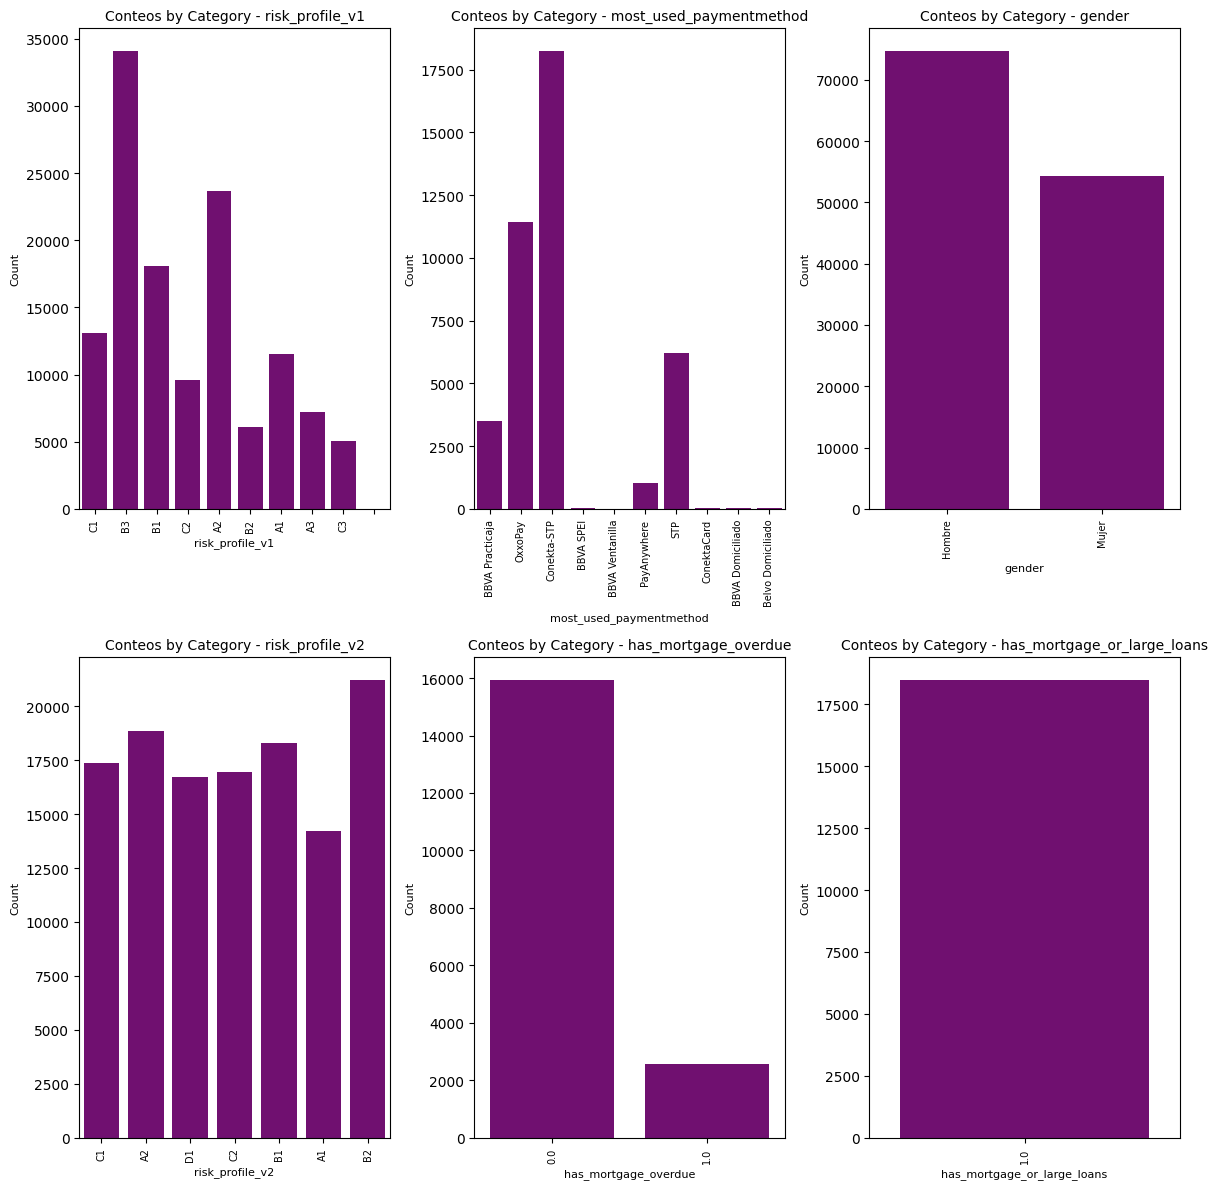

In [245]:
import matplotlib.pyplot as plt
import seaborn as sns

n_cols = 3
n_rows = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 12))
axes = axes.flatten()

# Plot each categorical feature in the grid
for i, col in enumerate(df_categoric):
    sns.countplot(data=df_categoric, x=col, ax=axes[i], color='purple')
    axes[i].set_title(f'Conteos by Category - {col}', fontsize=10)
    axes[i].set_xlabel(col, fontsize=8)
    axes[i].set_ylabel('Count', fontsize=8)
    axes[i].tick_params(axis='x', rotation=90, labelsize=7)

# Hide any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# <font color='#8789ed' face='Tahoma' size=5>Análisis de variables correlacionadas, entendimiento y selección</font> 

#### <font color='#b33b3b' face='Monaco' size=5>max_overdue vs days_of_worst_overdue</font> 

In [246]:
df_fc = df[['idobservation', 'id_userv3','max_overdue','days_of_worst_overdue']][(df['num_atrato_credits']==1)&(~df['max_overdue'].isna())]
df_fc['diff']=df_fc['max_overdue']-df_fc['days_of_worst_overdue']
df_fc.describe()

,id_userv3,max_overdue,days_of_worst_overdue,diff
count,50465.000000,50465.000000,50465.000000,50465.0
mean,263836.562112,16.424096,16.424096,0.0
std,174761.118116,21.743197,21.743197,0.0
min,6.000000,1.000000,1.000000,0.0
25%,114910.000000,3.000000,3.000000,0.0
50%,254325.000000,10.000000,10.000000,0.0
75%,393958.000000,19.000000,19.000000,0.0
max,701346.000000,473.000000,473.000000,0.0


In [247]:
df[df['idobservation'].isin(df_fc[df_fc['diff']<0]['idobservation'].to_list())][['id_userv3','payment_history','max_overdue','days_of_worst_overdue']]

,id_userv3,payment_history,max_overdue,days_of_worst_overdue


Revisar los 129 casos donde son diferentes (TEORÍA, MÁS DE UN CRÉDITO AL MISMO TIEMPO), por lo demás quedarse con **days_of_worst_overdue**

#### <font color='#b33b3b' face='Monaco' size=5>current_debt vs pct_credit_maturity</font>

In [248]:
df_sc = df[['idobservation','current_debt','pct_credit_maturity']]
df_sc

,idobservation,current_debt,pct_credit_maturity
0,3187-15,0.695,0.305
1,4557-11,0.626,0.374
2,4557-10,0.626,0.374
3,4557-12,0.507,0.493
4,6617-8,0.465,0.535
...,...,...,...
128883,1839553-1,NaN,NaN
128884,1848484-2,0.943,0.057
128885,1863038-1,0.950,0.051
128886,1881777-1,1.000,0.000


Parece que al sumarlas da 1, por lo que son complementarias, hacemos la comprobación.

In [249]:
df_sc['sum_pct'] = df_sc['current_debt'] + df_sc['pct_credit_maturity']
df_sc['sum_pct'].describe()

/tmp/ipykernel_1343/1783838561.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sc['sum_pct'] = df_sc['current_debt'] + df_sc['pct_credit_maturity']


count    119554.000000
mean          1.000001
std           0.000028
min           0.999000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.001000
Name: sum_pct, dtype: float64

SELECCIÓN :  tienen la misma correlación, quitarla del modelo, puede usarse para la segmentación final de los clientes

#### <font color='#b33b3b' face='Monaco' size=5>granted_credit_amount vs max_overdue_amount vs monthly_payment</font>

In [250]:
df_tc = df[['idobservation','granted_credit_amount', 'max_overdue_amount','montlhy_payment']]
df_tc = df_tc[~df_tc['max_overdue_amount'].isna()]
df_tc

,idobservation,granted_credit_amount,max_overdue_amount,montlhy_payment
1,4557-11,40000.00,3428.98000,3428.981610
2,4557-10,40000.00,3428.98000,3428.981610
3,4557-12,40000.00,3577.99839,3428.981610
6,7089-16,6000.00,765.00000,461.462078
7,7089-11,6000.00,765.00000,461.462078
...,...,...,...,...
128868,1835522-2,22400.00,3455.20000,3155.200000
128869,1840460-2,6168.82,2312.00000,2311.650000
128871,1847950-2,25000.00,1832.00000,3664.180000
128873,1872469-1,3000.00,534.00000,534.100000


In [251]:
df_tc['max_overdue_to_monthly_payment_ratio'] = df_tc['max_overdue_amount']/df_tc['montlhy_payment']
df_tc['max_overdue_to_monthly_payment_ratio'].describe()

count    92088.000000
mean         1.031588
std          0.274650
min          0.054163
25%          0.999979
50%          1.051806
75%          1.157678
max          9.881344
Name: max_overdue_to_monthly_payment_ratio, dtype: float64

In [252]:
df_tc[df_tc['max_overdue_to_monthly_payment_ratio']<1].describe()

,granted_credit_amount,max_overdue_amount,montlhy_payment,max_overdue_to_monthly_payment_ratio
count,23694.000000,23694.000000,23694.000000,23694.000000
mean,14376.450662,1305.470268,1971.549074,0.703900
std,12595.850407,1021.080066,1557.487334,0.204617
min,700.560000,79.000000,148.460000,0.054163
25%,6267.000000,700.000000,1029.520000,0.510605
50%,10000.000000,1067.400000,1565.620000,0.638582
75%,18000.000000,1592.000000,2411.840000,0.965513
max,200000.000000,22645.300000,36938.950000,1.000000


La mayoría de las personas deben 1 mensualidad, pero hay gente que debe menos

SUGERENCIA: Usar monto del préstamo para segmentar o el pago mensual.

NOTA: Recordar que los clientes a veces pagan en cuotas una mensualidad, por la que si deben haber casos donde el max_overdue amount sea distinto de la cuota mensual. Quizá usar ratio en lugar de valores por separado

#### <font color='#b33b3b' face='Monaco' size=5>historical_overdue_atrato_credits vs num_atrato_credits

 num_atrato_credits</font>

In [253]:
df['num_atrato_credits'].value_counts(normalize=True)*100

num_atrato_credits
1.0     55.717246
2.0     24.002111
3.0     11.732520
4.0      5.034654
5.0      2.190195
6.0      0.798622
7.0      0.312774
8.0      0.147462
9.0      0.029492
10.0     0.026388
11.0     0.003104
12.0     0.002328
15.0     0.001552
17.0     0.001552
Name: proportion, dtype: float64

In [254]:
df_cc = df[['num_atrato_credits','historical_overdue_atrato_credits']]
df_cc['diff'] = df_cc['num_atrato_credits']-df_cc['historical_overdue_atrato_credits']
df_cc[df_cc['diff']==0].shape[0]/df.shape[0]*100

/tmp/ipykernel_1343/2997433811.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cc['diff'] = df_cc['num_atrato_credits']-df_cc['historical_overdue_atrato_credits']


88.46905840729936

El 93 % de la población se ha atrasado en todos sus créditos, pueden no haber llegado a un bucket de mora de cobranza.

Quizá hacer un ratio o eliminarla del modelo

#### <font color='#b33b3b' face='Monaco' size=5>paid_late_comission_amount vs pending_late_comission </font>

Por definición son conceptos diferentes, pueden estar correlacionadas debido a que son múltiplos de 300 amnbas variables. Una cosa es cuantas comisiones debe y cuántas ha pagado, puede compararse vs el número de veces que se ha atrasado para ver el porcentaje de comisiones ha pagado.